# Extracting Attributes from Fashion Images Jan 2024


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from helper_funcs import create_tensorboard_callback, create_checkpoint_callback, plot_loss_curves, compare_historys, unzip_data, calculate_results
import tensorflow_hub as hub
import shutil

In [4]:
DIR_NAME = 'extracting-attributes-from-fashion-images-jan-2024/'

dataset = pd.read_csv(f'{DIR_NAME}train.csv')
# dataset['image'] = np.zeros((len(dataset), 224, 224, 3))
dataset.head()

,file_name,label
0,Image_train_00001.jpg,0
1,Image_train_00002.jpg,1
2,Image_train_00003.jpg,0
3,Image_train_00004.jpg,0
4,Image_train_00005.jpg,0


In [4]:
!rm -rf extracting-attributes-from-fashion-images-jan-2024/train_data

os.mkdir(f'{DIR_NAME}train_data')

progbar = tf.keras.utils.Progbar(len(dataset))

for i in dataset['label'].unique():
    if not os.path.isdir(f'{DIR_NAME}train_data/{i}'):
        os.mkdir(f'{DIR_NAME}train_data/{i}')
for i, row in dataset.iterrows():
    progbar.update(i)
    if not os.path.isdir(f'{DIR_NAME}train_data/{row["label"]}'):
        os.mkdir(f'{DIR_NAME}train_data/{row["label"]}')
    shutil.copy(f'{DIR_NAME}train/{row["file_name"]}', f'{DIR_NAME}train_data/{row["label"]}/{row["file_name"]}')

progbar.update(len(dataset))

18391/18391 [==============================] - 6s 307us/step


In [5]:
label = np.bincount(dataset['label'])
total = np.sum(label)
for i, j in enumerate(label):
    print(f'{i}: {j} ({j/total*100:.2f}%)')

0: 1402 (7.62%)
1: 5384 (29.28%)
2: 4084 (22.21%)
3: 2008 (10.92%)
4: 1972 (10.72%)
5: 1616 (8.79%)
6: 1925 (10.47%)


In [6]:
for dirpath, dirnames, filenames in os.walk(DIR_NAME):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")


There are 3 directories and 3 files in 'extracting-attributes-from-fashion-images-jan-2024/'.
There are 0 directories and 5751 files in 'extracting-attributes-from-fashion-images-jan-2024/test'.
There are 7 directories and 0 files in 'extracting-attributes-from-fashion-images-jan-2024/train_data'.
There are 0 directories and 1402 files in 'extracting-attributes-from-fashion-images-jan-2024/train_data/0'.
There are 0 directories and 1925 files in 'extracting-attributes-from-fashion-images-jan-2024/train_data/6'.
There are 0 directories and 5384 files in 'extracting-attributes-from-fashion-images-jan-2024/train_data/1'.
There are 0 directories and 1972 files in 'extracting-attributes-from-fashion-images-jan-2024/train_data/4'.
There are 0 directories and 2008 files in 'extracting-attributes-from-fashion-images-jan-2024/train_data/3'.
There are 0 directories and 4084 files in 'extracting-attributes-from-fashion-images-jan-2024/train_data/2'.
There are 0 directories and 1616 files in 'extr

In [7]:
all_data = tf.keras.preprocessing.image_dataset_from_directory(
    f'{DIR_NAME}train_data',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    label_mode='categorical',
    seed=42,
)

import itertools
all_data_labels = tf.argmax(list(itertools.chain.from_iterable([y for x, y in all_data])), axis=1)
all_data_labels

Found 18391 files belonging to 7 classes.


2024-01-22 13:00:48.398852: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-22 13:00:48.398875: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-22 13:00:48.398883: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-22 13:00:48.398956: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-22 13:00:48.398980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<tf.Tensor: shape=(18391,), dtype=int64, numpy=array([0, 0, 0, ..., 6, 6, 6])>

In [9]:
train_data, validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    f'{DIR_NAME}train_data',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset='both',
    seed=42,
)

Found 18391 files belonging to 7 classes.
Using 14713 files for training.
Using 3678 files for validation.


In [10]:
class_names = train_data.class_names
class_names

['0', '1', '2', '3', '4', '5', '6']

In [12]:
import itertools
validation_labels = []
validation_data1 = []
for x, y in validation_data:
    for x1, y1 in zip(x, y):
        validation_data1.append(x1)
        validation_labels.append(tf.argmax(y1))
# validation_labels = tf.argmax(list(itertools.chain.from_iterable([y for x, y in validation_data])), axis=1)
validation_labels = np.array(validation_labels)
validation_data1 = np.array(validation_data1)
validation_data = validation_data1
validation_data1.shape, validation_labels.shape

((3678, 224, 224, 3), (3678,))

In [265]:
train_data = train_data.shuffle(20000).prefetch(tf.data.AUTOTUNE)

In [10]:
total_train = 0
for imgs, label in train_data:
    for img in imgs:
        total_train += 1
total_train

14713

In [11]:
total_validation = 0
for imgs, label in validation_data:
    for img in imgs:
        total_validation += 1
total_validation

3678

In [12]:
len(train_data), len(validation_data)

(460, 115)

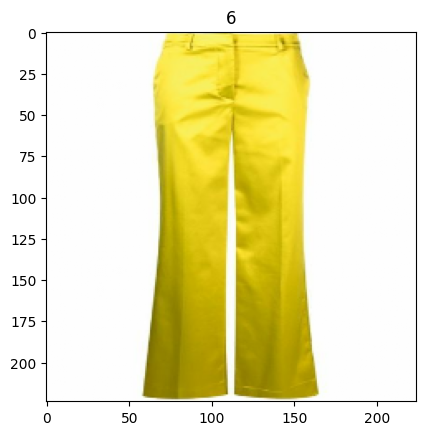

In [13]:
for images, labels in train_data.take(1):
    plt.imshow(images[0]/255.)
    plt.title(class_names[tf.argmax(labels[0])])

## Creating Model

### Creating Callbacks

In [15]:
def get_callbacks(experiment_name, use_early_stopping = False, patience=3):
    if use_early_stopping:
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience,
            restore_best_weights=True,
        )
    callbacks = [
        create_tensorboard_callback(
            dir_name="attributes_from_fashion/tensorboard",
            experiment_name=experiment_name,
        ),
        create_checkpoint_callback(
            dir_name="attributes_from_fashion/checkpoint",
            experiment_name=experiment_name,
        ),
    ]
    if use_early_stopping:
        callbacks.append(early_stopping)
    return callbacks

### Model 0: Baseline model

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_0/20240120-130625
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_0/checkpoint.ckpt
Epoch 1/5


2024-01-20 13:06:25.185744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


460/460 [==============================] - 27s 57ms/step - loss: 2.4731 - accuracy: 0.3430 - val_loss: 1.5719 - val_accuracy: 0.4103
Epoch 2/5
460/460 [==============================] - 26s 56ms/step - loss: 1.1626 - accuracy: 0.5739 - val_loss: 1.6283 - val_accuracy: 0.4233
Epoch 3/5
460/460 [==============================] - 26s 55ms/step - loss: 0.7651 - accuracy: 0.7428 - val_loss: 1.8271 - val_accuracy: 0.4369
Epoch 4/5
460/460 [==============================] - 25s 54ms/step - loss: 0.5259 - accuracy: 0.8376 - val_loss: 1.9562 - val_accuracy: 0.4328
Epoch 5/5
115/115 [==============================] - 2s 16ms/step


{'accuracy': 43.66503534529635,
 'precision': 0.4448292224235196,
 'recall': 0.43665035345296355,
 'f1': 0.4257498145627391}

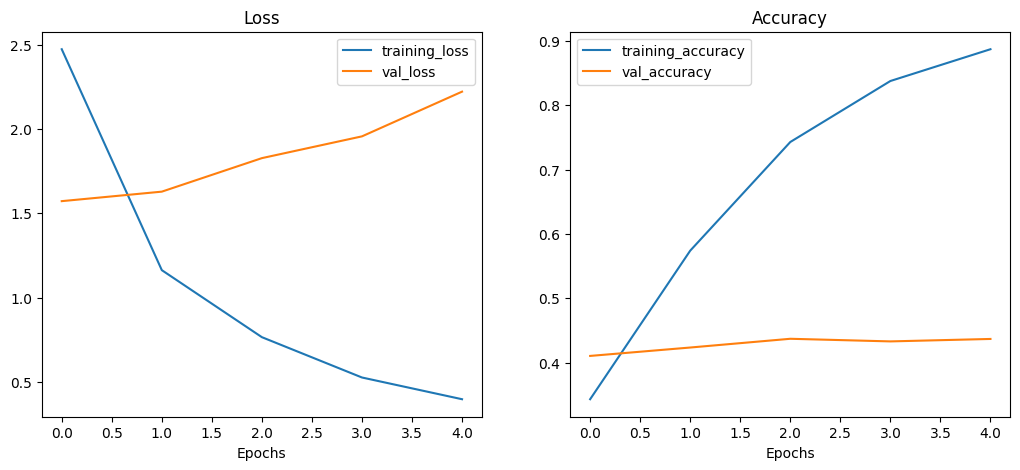

In [14]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_0 = tf.keras.models.Model(inputs, outputs)

model_0.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_0 = model_0.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=get_callbacks('model_0'),
)

model_0_preds = (tf.argmax(model_0.predict(validation_data), axis=1))
model_0_results = calculate_results(y_true=validation_labels, y_pred=model_0_preds)

plot_loss_curves(history_0)

model_0_results

In [18]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 7)                 2759911   
                                                             

### Model 1: Trying classweights for data imbalance

In [30]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}
class_weights

{0: 1.8739555736702669,
 1: 0.4879802589683719,
 2: 0.6433118791101161,
 3: 1.3084092202618098,
 4: 1.3322949869603014,
 5: 1.6257956152758133,
 6: 1.3648237476808904}

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_1
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_1/checkpoint.ckpt
Epoch 1/5
460/460 [==============================] - 30s 63ms/step - loss: 1.9949 - accuracy: 0.2715 - val_loss: 1.6652 - val_accuracy: 0.3461
Epoch 2/5
460/460 [==============================] - 29s 62ms/step - loss: 1.1337 - accuracy: 0.5333 - val_loss: 1.6436 - val_accuracy: 0.3902
Epoch 3/5
460/460 [==============================] - 29s 62ms/step - loss: 0.6801 - accuracy: 0.7315 - val_loss: 2.0227 - val_accuracy: 0.3937
Epoch 4/5
460/460 [==============================] - 28s 59ms/step - loss: 0.4513 - accuracy: 0.8333 - val_loss: 1.9775 - val_accuracy: 0.4163
Epoch 5/5
115/115 [==============================] - 2s 16ms/step


{'accuracy': 43.33877107123437,
 'precision': 0.4375986489042861,
 'recall': 0.43338771071234367,
 'f1': 0.4328859249082307}

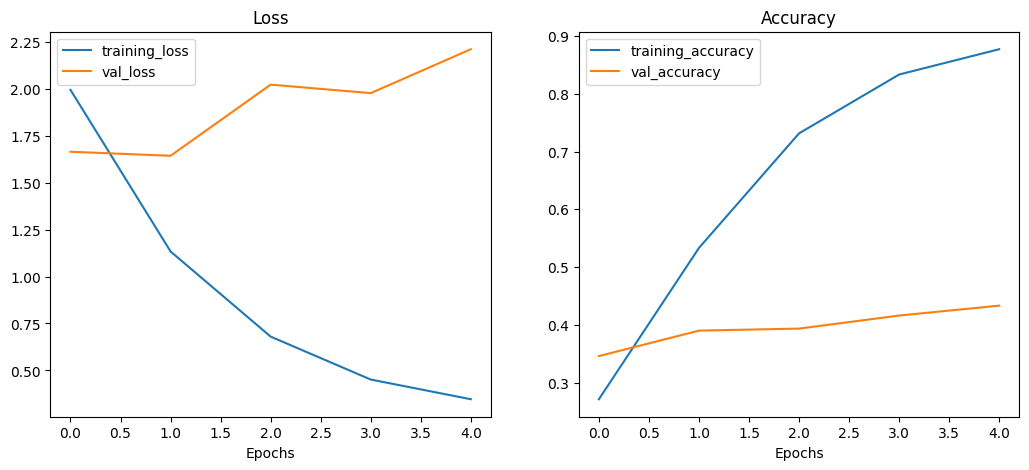

In [31]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_1 = tf.keras.models.Model(inputs, outputs)

model_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_1 = model_1.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    class_weight=class_weights,
    callbacks=get_callbacks('model_1'),
)

model_1_preds = (tf.argmax(model_1.predict(validation_data), axis=1))
model_1_results = calculate_results(y_true=validation_labels, y_pred=model_1_preds)

plot_loss_curves(history_1)

model_1_results

### Model 2
- Model 1 did not perform better than model 0 therefore reducing the class weight param from / len() to len() - 1

In [32]:
class_weights = {i: total / ((len(label) - 1) * j) for i, j in enumerate(label)}
class_weights

{0: 2.1862815026153113,
 1: 0.5693103021297672,
 2: 0.7505305256284688,
 3: 1.5264774236387781,
 4: 1.5543441514536849,
 5: 1.8967615511551155,
 6: 1.5922943722943723}

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_2
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_2/checkpoint.ckpt
Epoch 1/5
460/460 [==============================] - 29s 61ms/step - loss: 3.3369 - accuracy: 0.2613 - val_loss: 1.7347 - val_accuracy: 0.3067
Epoch 2/5
460/460 [==============================] - 29s 62ms/step - loss: 1.4035 - accuracy: 0.5151 - val_loss: 1.6641 - val_accuracy: 0.3825
Epoch 3/5
460/460 [==============================] - 29s 62ms/step - loss: 0.8635 - accuracy: 0.7126 - val_loss: 2.0283 - val_accuracy: 0.3961
Epoch 4/5
460/460 [==============================] - 29s 62ms/step - loss: 0.5843 - accuracy: 0.8196 - val_loss: 2.2574 - val_accuracy: 0.3975
Epoch 5/5
115/115 [==============================] - 2s 16ms/step


{'accuracy': 39.34203371397499,
 'precision': 0.41147046559640005,
 'recall': 0.3934203371397499,
 'f1': 0.394388683409777}

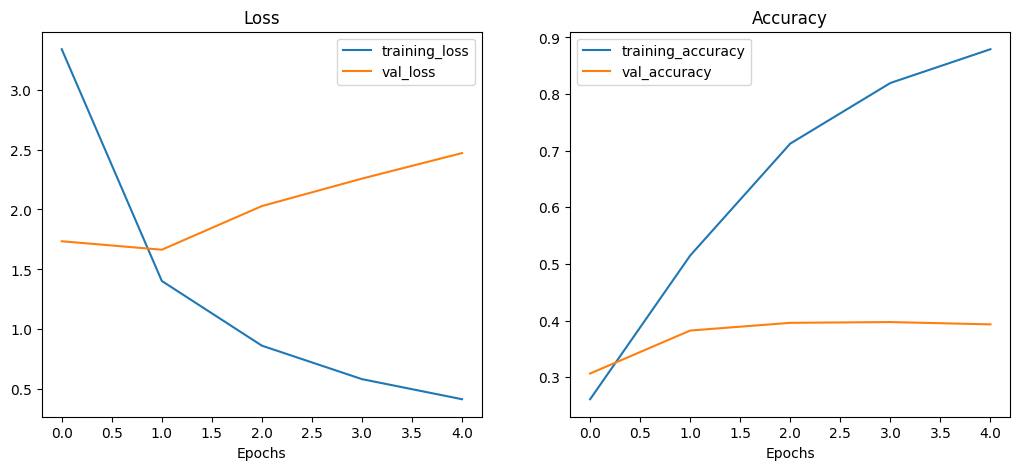

In [34]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_2 = tf.keras.models.Model(inputs, outputs)

model_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_2 = model_2.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    class_weight=class_weights,
    callbacks=get_callbacks('model_2'),
)

model_2_preds = (tf.argmax(model_2.predict(validation_data), axis=1))
model_2_results = calculate_results(y_true=validation_labels, y_pred=model_2_preds)

plot_loss_curves(history_2)

model_2_results

### Model 3

- Did not improve using correct class weights
- Changing Conv2D from 32, 3 filters to 64, 5

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_3
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_3/checkpoint.ckpt
Epoch 1/5
460/460 [==============================] - 57s 121ms/step - loss: 2.4269 - accuracy: 0.2643 - val_loss: 1.7341 - val_accuracy: 0.3127
Epoch 2/5
460/460 [==============================] - 54s 117ms/step - loss: 1.1946 - accuracy: 0.5110 - val_loss: 1.8690 - val_accuracy: 0.3613
Epoch 3/5
460/460 [==============================] - 53s 115ms/step - loss: 0.7619 - accuracy: 0.6899 - val_loss: 2.0694 - val_accuracy: 0.3980
Epoch 4/5
460/460 [==============================] - 53s 114ms/step - loss: 0.5227 - accuracy: 0.7928 - val_loss: 2.3975 - val_accuracy: 0.4057
Epoch 5/5
115/115 [==============================] - 3s 27ms/step


{'accuracy': 39.668297988036976,
 'precision': 0.4217935805441495,
 'recall': 0.39668297988036977,
 'f1': 0.394510565454522}

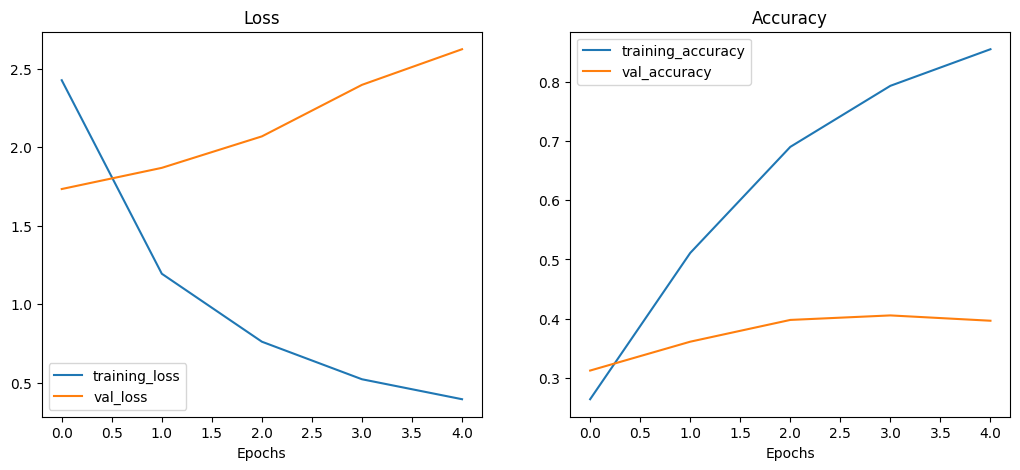

In [35]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}


inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_3 = tf.keras.models.Model(inputs, outputs)

model_3.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_3 = model_3.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    class_weight=class_weights,
    callbacks=get_callbacks('model_3'),
)

model_3_preds = (tf.argmax(model_3.predict(validation_data), axis=1))
model_3_results = calculate_results(y_true=validation_labels, y_pred=model_3_preds)

plot_loss_curves(history_3)

model_3_results

### Model 4

- The Accuracy decreased, but so did overfitting, so trying out batch norm layer

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_3
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_3/checkpoint.ckpt
Epoch 1/5
460/460 [==============================] - 62s 131ms/step - loss: 3.4608 - accuracy: 0.2672 - val_loss: 1.7286 - val_accuracy: 0.3524
Epoch 2/5
460/460 [==============================] - 63s 136ms/step - loss: 1.3299 - accuracy: 0.4714 - val_loss: 2.0261 - val_accuracy: 0.3388
Epoch 3/5
460/460 [==============================] - 61s 132ms/step - loss: 0.9285 - accuracy: 0.6444 - val_loss: 2.5102 - val_accuracy: 0.3649
Epoch 4/5
460/460 [==============================] - 61s 132ms/step - loss: 0.6153 - accuracy: 0.7642 - val_loss: 3.3755 - val_accuracy: 0.3369
Epoch 5/5
115/115 [==============================] - 4s 30ms/step


{'accuracy': 36.67754214246873,
 'precision': 0.3830605368124351,
 'recall': 0.36677542142468733,
 'f1': 0.37084408105272215}

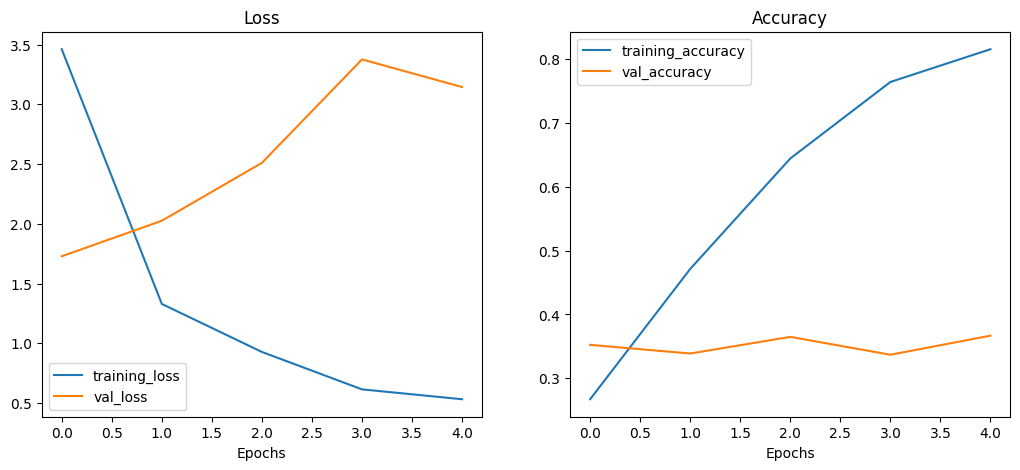

In [36]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}


inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_4 = tf.keras.models.Model(inputs, outputs)

model_4.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_4 = model_4.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    class_weight=class_weights,
    callbacks=get_callbacks('model_4'),
)

model_4_preds = (tf.argmax(model_4.predict(validation_data), axis=1))
model_4_results = calculate_results(y_true=validation_labels, y_pred=model_4_preds)

plot_loss_curves(history_4)

model_4_results

### Model 5

- Adding zoom, rotation, width and height shift to the image augmentation to reduce overfitting

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_3
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_3/checkpoint.ckpt
Epoch 1/5
460/460 [==============================] - 55s 117ms/step - loss: 2.3738 - accuracy: 0.2356 - val_loss: 1.7391 - val_accuracy: 0.3026
Epoch 2/5
460/460 [==============================] - 53s 115ms/step - loss: 1.3540 - accuracy: 0.4428 - val_loss: 1.6825 - val_accuracy: 0.3801
Epoch 3/5
460/460 [==============================] - 54s 117ms/step - loss: 0.8380 - accuracy: 0.6560 - val_loss: 1.7935 - val_accuracy: 0.4217
Epoch 4/5
460/460 [==============================] - 56s 121ms/step - loss: 0.5637 - accuracy: 0.7794 - val_loss: 2.0181 - val_accuracy: 0.4258
Epoch 5/5
115/115 [==============================] - 3s 26ms/step


{'accuracy': 42.98531810766721,
 'precision': 0.43033691830118964,
 'recall': 0.4298531810766721,
 'f1': 0.42385574840641044}

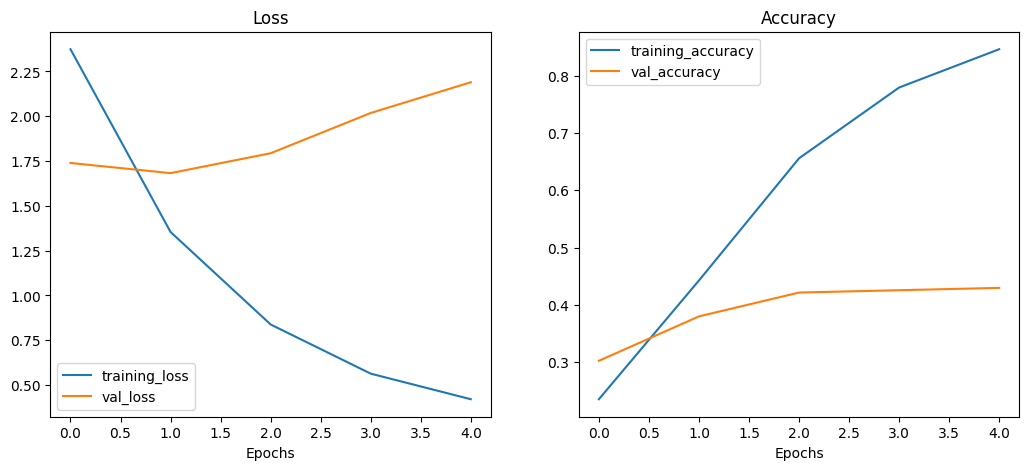

In [37]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}


inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_5 = tf.keras.models.Model(inputs, outputs)

model_5.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_5 = model_5.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    class_weight=class_weights,
    callbacks=get_callbacks('model_5'),
)

model_5_preds = (tf.argmax(model_5.predict(validation_data), axis=1))
model_5_results = calculate_results(y_true=validation_labels, y_pred=model_5_preds)

plot_loss_curves(history_5)

model_5_results

### Model 6

- Overfitting decreased
- Adding another conv2d before maxpool

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_5
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_5/checkpoint.ckpt
Epoch 1/5
460/460 [==============================] - 277s 599ms/step - loss: 2.0685 - accuracy: 0.1645 - val_loss: 1.8312 - val_accuracy: 0.2102
Epoch 2/5
460/460 [==============================] - 264s 574ms/step - loss: 1.6867 - accuracy: 0.2986 - val_loss: 1.8306 - val_accuracy: 0.2667
Epoch 3/5
460/460 [==============================] - 280s 608ms/step - loss: 1.3640 - accuracy: 0.4369 - val_loss: 1.8903 - val_accuracy: 0.3097
Epoch 4/5
460/460 [==============================] - 277s 602ms/step - loss: 1.1473 - accuracy: 0.5344 - val_loss: 2.1832 - val_accuracy: 0.3293
Epoch 5/5
115/115 [==============================] - 16s 142ms/step


{'accuracy': 34.99184339314845,
 'precision': 0.3568475499449305,
 'recall': 0.34991843393148453,
 'f1': 0.3504066458539717}

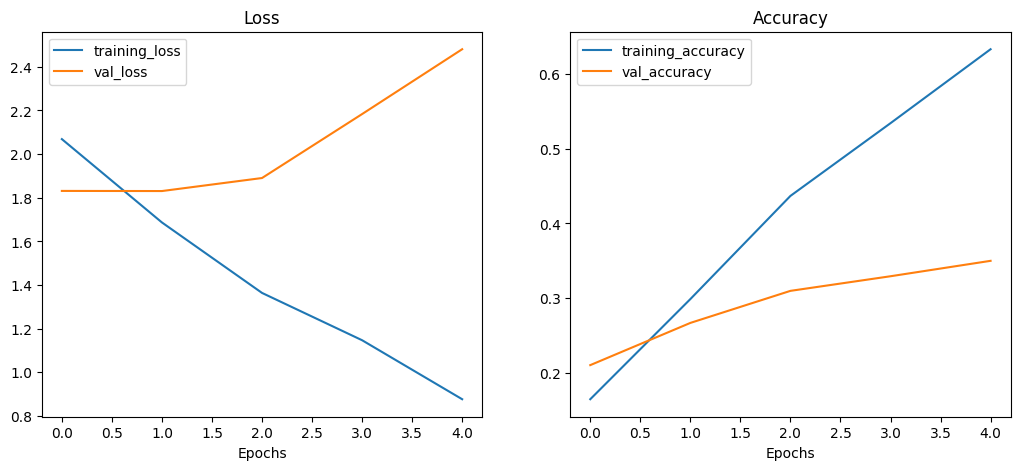

In [38]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}


inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_6 = tf.keras.models.Model(inputs, outputs)

model_6.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_6 = model_6.fit(
    train_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    class_weight=class_weights,
    callbacks=get_callbacks('model_6'),
)

model_6_preds = (tf.argmax(model_6.predict(validation_data), axis=1))
model_6_results = calculate_results(y_true=validation_labels, y_pred=model_6_preds)

plot_loss_curves(history_6)

model_6_results

### Model 7

- Overfitting decreased
- Adding another conv2d, conv2d, maxpool2d layer

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_7/20240122-102551
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_7/checkpoint.ckpt
Epoch 1/10
460/460 [==============================] - 273s 593ms/step - loss: 1.8292 - accuracy: 0.2206 - val_loss: 1.6992 - val_accuracy: 0.3064
Epoch 2/10
460/460 [==============================] - 272s 590ms/step - loss: 1.4192 - accuracy: 0.4031 - val_loss: 1.5358 - val_accuracy: 0.3961
Epoch 3/10
460/460 [==============================] - 272s 591ms/step - loss: 1.1118 - accuracy: 0.5219 - val_loss: 1.5844 - val_accuracy: 0.4502
Epoch 4/10
460/460 [==============================] - 272s 592ms/step - loss: 0.8599 - accuracy: 0.6245 - val_loss: 1.8212 - val_accuracy: 0.4638
Epoch 5/10
460/460 [==============================] - 272s 592ms/step - loss: 0.6421 - accuracy: 0.7173 - val_loss: 2.2693 - val_accuracy: 0.4606
Epoch 6/10
460/460 [==============================] - 272s 590ms/step - loss: 0.5219 - ac

{'accuracy': 47.49864056552474,
 'precision': 0.4782572358655101,
 'recall': 0.4749864056552474,
 'f1': 0.47552776215709924}

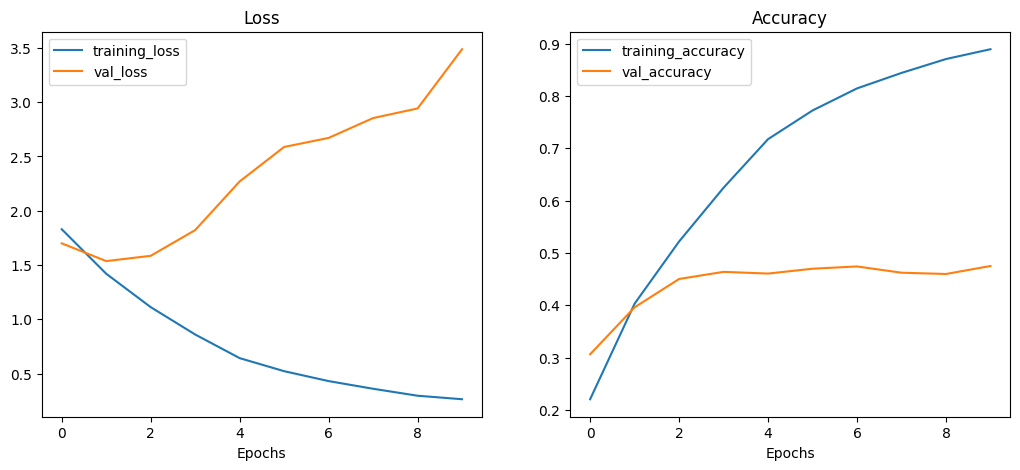

In [217]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}


inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(32, 5, activation='relu')(x)
x = tf.keras.layers.Conv2D(32, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_7 = tf.keras.models.Model(inputs, outputs)

model_7.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_7 = model_7.fit(
    train_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    class_weight=class_weights,
    callbacks=get_callbacks('model_7', True, 10),
)

model_7_preds = (tf.argmax(model_7.predict(validation_data), axis=1))
model_7_results = calculate_results(y_true=validation_labels, y_pred=model_7_preds)

plot_loss_curves(history_7)

model_7_results

## Using 10% of data to train because of time constraints

In [17]:
train_data_10_percent = train_data.take(int(0.1 * len(train_data)))

In [18]:
train_data_10_percent_len = 0
for imgs, label in train_data_10_percent:
    for img in imgs:
        train_data_10_percent_len+=1
train_data_10_percent_len

1472

In [19]:
(len(train_data) * 0.1) * 32

1472.0

In [47]:
validation_data_15_percent = validation_data.take(int(0.15 * len(validation_data)))

In [82]:
validation_data_15_percent_len = 0
for imgs, _ in validation_data_15_percent:
    for img in imgs:
        validation_data_15_percent_len+=1
validation_data_15_percent_len

544

### Model S 1

- S stands for Small
- Constructing our baseline model for 10% data

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_0/20240120-130835
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_0/checkpoint.ckpt
Epoch 1/5
46/46 [==============================] - 3s 62ms/step - loss: 6.6589 - accuracy: 0.2337 - val_loss: 1.8777 - val_accuracy: 0.2708
Epoch 2/5
46/46 [==============================] - 3s 58ms/step - loss: 1.6297 - accuracy: 0.4769 - val_loss: 1.8315 - val_accuracy: 0.2969
Epoch 3/5
46/46 [==============================] - 3s 57ms/step - loss: 1.0293 - accuracy: 0.7004 - val_loss: 1.8426 - val_accuracy: 0.3333
Epoch 4/5
46/46 [==============================] - 3s 56ms/step - loss: 0.6121 - accuracy: 0.8268 - val_loss: 2.0252 - val_accuracy: 0.3333
Epoch 5/5
115/115 [==============================] - 2s 16ms/step


{'accuracy': 32.78955954323002,
 'precision': 0.36542389238155465,
 'recall': 0.3278955954323002,
 'f1': 0.31095582867395044}

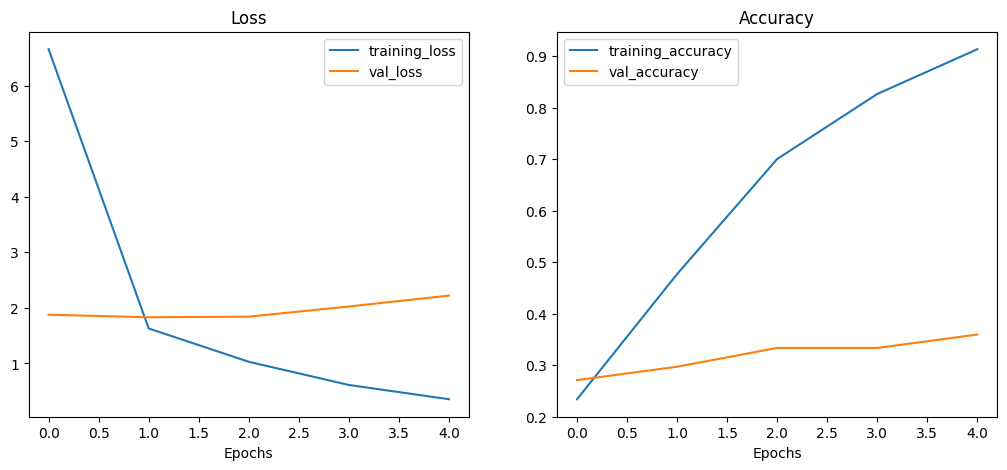

In [18]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_0 = tf.keras.models.Model(inputs, outputs)

model_s_0.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_0 = model_s_0.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data,
    validation_steps=0.15 * len(validation_data),
    callbacks=get_callbacks('model_s_0'),
)

model_s_0_preds = (tf.argmax(model_s_0.predict(validation_data), axis=1))
model_s_0_results = calculate_results(y_true=validation_labels, y_pred=model_s_0_preds)

plot_loss_curves(history_s_0)

model_s_0_results

### Model S 2

- Copy of Model 7

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_1/20240120-130852
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_1/checkpoint.ckpt
Epoch 1/10
46/46 [==============================] - 31s 658ms/step - loss: 1.9118 - accuracy: 0.2758 - val_loss: 1.8893 - val_accuracy: 0.2309
Epoch 2/10
46/46 [==============================] - 31s 677ms/step - loss: 1.7955 - accuracy: 0.2833 - val_loss: 1.7850 - val_accuracy: 0.2760
Epoch 3/10
46/46 [==============================] - 31s 677ms/step - loss: 1.7516 - accuracy: 0.3050 - val_loss: 1.8242 - val_accuracy: 0.2882
Epoch 4/10
46/46 [==============================] - 31s 674ms/step - loss: 1.6145 - accuracy: 0.3716 - val_loss: 1.7707 - val_accuracy: 0.2726
Epoch 5/10
46/46 [==============================] - 31s 679ms/step - loss: 1.3621 - accuracy: 0.4769 - val_loss: 1.7199 - val_accuracy: 0.3576
Epoch 6/10
46/46 [==============================] - 31s 672ms/step - loss: 1.1055 - accuracy: 0.5924

{'accuracy': 33.251767264817836,
 'precision': 0.3320057346547367,
 'recall': 0.33251767264817833,
 'f1': 0.3303579563578814}

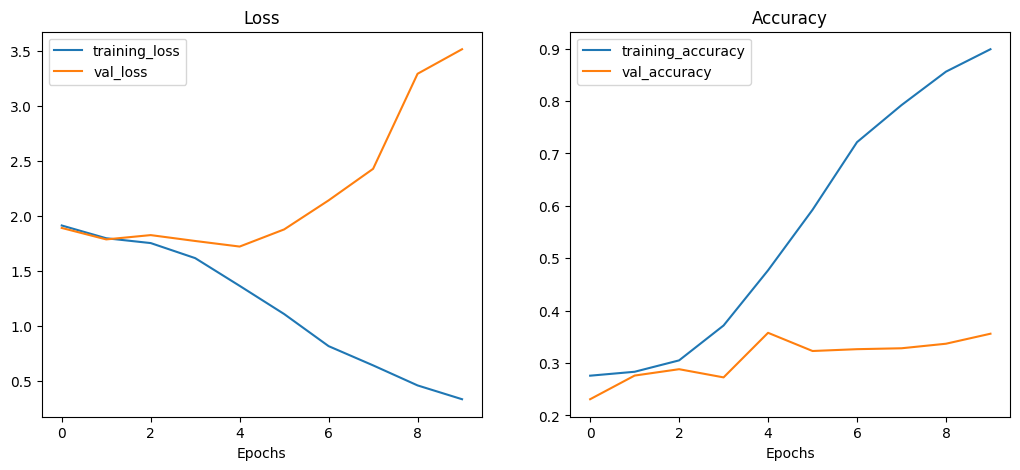

In [19]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}


inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(32, 5, activation='relu')(x)
x = tf.keras.layers.Conv2D(32, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_1 = tf.keras.models.Model(inputs, outputs)

model_s_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_1 = model_s_1.fit(
    train_data_10_percent,
    epochs=10,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data,
    validation_steps=0.15 * len(validation_data),
    callbacks=get_callbacks('model_s_1'),
)

model_s_1_preds = (tf.argmax(model_s_1.predict(validation_data), axis=1))
model_s_1_results = calculate_results(y_true=validation_labels, y_pred=model_s_1_preds)

plot_loss_curves(history_s_1)

model_s_1_results

### Model S 3

- Adding a dense layer after the flatten layer


Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_2/20240120-135001
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_2/checkpoint.ckpt
Epoch 1/10
46/46 [==============================] - 33s 705ms/step - loss: 5.5507 - accuracy: 0.1909 - val_loss: 4.4726 - val_accuracy: 0.2292
Epoch 2/10
46/46 [==============================] - 31s 682ms/step - loss: 11.9499 - accuracy: 0.1929 - val_loss: 2.9449 - val_accuracy: 0.1910
Epoch 3/10
46/46 [==============================] - 32s 694ms/step - loss: 2.1679 - accuracy: 0.2588 - val_loss: 1.9087 - val_accuracy: 0.2309
Epoch 4/10
46/46 [==============================] - 31s 682ms/step - loss: 2.0110 - accuracy: 0.2962 - val_loss: 3.9272 - val_accuracy: 0.1562
Epoch 5/10
46/46 [==============================] - 31s 671ms/step - loss: 4.2248 - accuracy: 0.2520 - val_loss: 3.5466 - val_accuracy: 0.2396
Epoch 6/10
46/46 [==============================] - 31s 682ms/step - loss: 3.5548 - accuracy: 0.251

/Users/mufaddalhamid/Documents/Learn/TensorFlow/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 29.690048939641112,
 'precision': 0.19663637929149919,
 'recall': 0.2969004893964111,
 'f1': 0.14532585093289171}

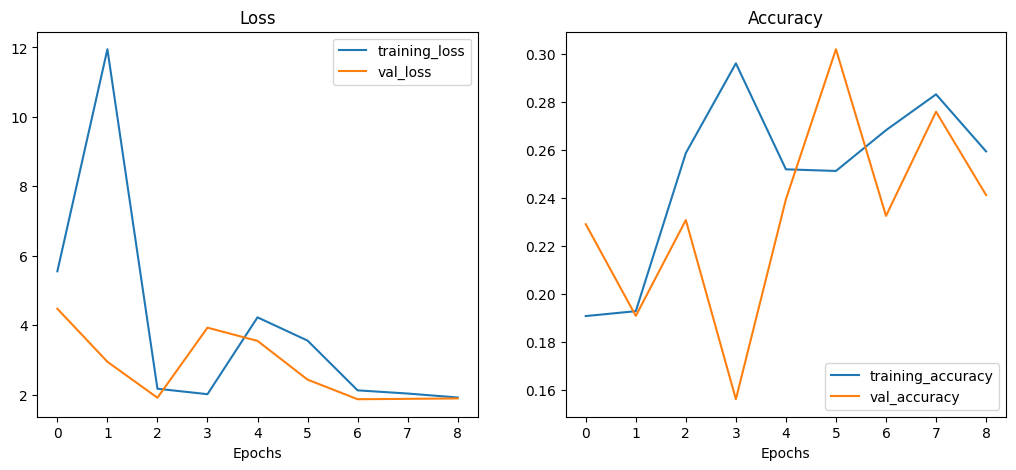

In [24]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}


inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(32, 5, activation='relu')(x)
x = tf.keras.layers.Conv2D(32, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_2 = tf.keras.models.Model(inputs, outputs)

model_s_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_2 = model_s_2.fit(
    train_data_10_percent,
    epochs=10,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data,
    validation_steps=0.15 * len(validation_data),
    callbacks=get_callbacks('model_s_2', True),
)

model_s_2_preds = (tf.argmax(model_s_2.predict(validation_data), axis=1))
model_s_2_results = calculate_results(y_true=validation_labels, y_pred=model_s_2_preds)

plot_loss_curves(history_s_2)

model_s_2_results

### Model S 4

- Replacing Conv2D Conv2D MaxPool2D with Conv2D MaxPool2D Conv2D MaxPool2D

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_4/20240120-135505
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_4/checkpoint.ckpt
Epoch 1/10
46/46 [==============================] - 11s 224ms/step - loss: 1.8711 - accuracy: 0.2860 - val_loss: 1.7972 - val_accuracy: 0.3108
Epoch 2/10
46/46 [==============================] - 10s 221ms/step - loss: 1.8244 - accuracy: 0.2738 - val_loss: 1.8266 - val_accuracy: 0.2309
Epoch 3/10
46/46 [==============================] - 10s 221ms/step - loss: 1.8041 - accuracy: 0.2901 - val_loss: 1.7735 - val_accuracy: 0.3247
Epoch 4/10
46/46 [==============================] - 10s 220ms/step - loss: 1.7262 - accuracy: 0.3268 - val_loss: 1.7096 - val_accuracy: 0.3316
Epoch 5/10
46/46 [==============================] - 10s 221ms/step - loss: 1.5933 - accuracy: 0.3872 - val_loss: 1.6785 - val_accuracy: 0.3646
Epoch 6/10
46/46 [==============================] - 10s 219ms/step - loss: 1.5586 - accuracy: 0.3838

{'accuracy': 37.41163675910821,
 'precision': 0.41124604038804236,
 'recall': 0.37411636759108213,
 'f1': 0.3784670010794156}

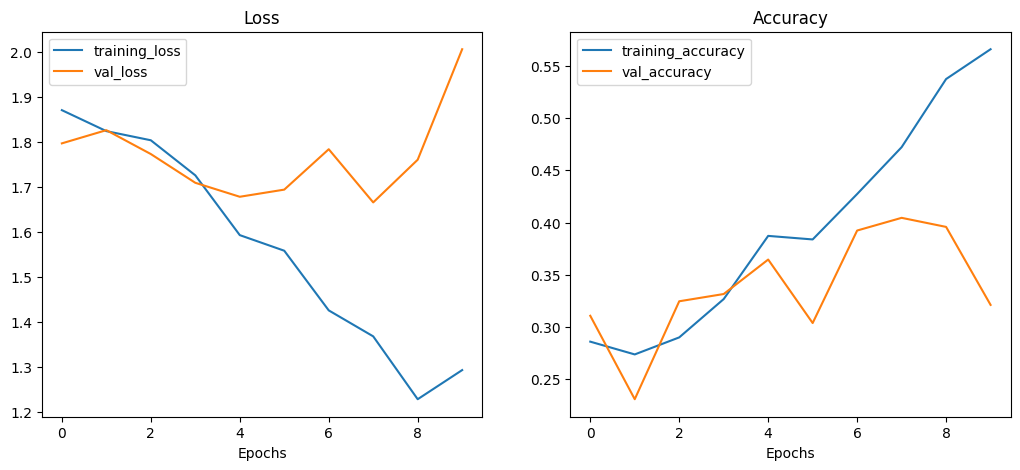

In [25]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}


inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(32, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(32, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_4 = tf.keras.models.Model(inputs, outputs)

model_s_4.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_4 = model_s_4.fit(
    train_data_10_percent,
    epochs=10,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data,
    validation_steps=0.15 * len(validation_data),
    callbacks=get_callbacks('model_s_4', True),
)

model_s_4_preds = (tf.argmax(model_s_4.predict(validation_data), axis=1))
model_s_4_results = calculate_results(y_true=validation_labels, y_pred=model_s_4_preds)

plot_loss_curves(history_s_4)

model_s_4_results

### Model s 5

- Changing Conv2D Params

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_5/20240120-144410
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_5/checkpoint.ckpt
Epoch 1/10
46/46 [==============================] - 37s 794ms/step - loss: 1.8409 - accuracy: 0.2785 - val_loss: 1.8245 - val_accuracy: 0.2309
Epoch 2/10
46/46 [==============================] - 35s 751ms/step - loss: 1.8254 - accuracy: 0.2765 - val_loss: 1.8069 - val_accuracy: 0.2309
Epoch 3/10
46/46 [==============================] - 35s 755ms/step - loss: 1.7770 - accuracy: 0.2819 - val_loss: 1.7653 - val_accuracy: 0.3038
Epoch 4/10
46/46 [==============================] - 35s 755ms/step - loss: 1.8768 - accuracy: 0.3043 - val_loss: 2.1103 - val_accuracy: 0.1059
Epoch 5/10
46/46 [==============================] - 37s 800ms/step - loss: 1.7723 - accuracy: 0.2962 - val_loss: 1.7687 - val_accuracy: 0.3403
Epoch 6/10
46/46 [==============================] - 36s 788ms/step - loss: 1.8525 - accuracy: 0.3519

/Users/mufaddalhamid/Documents/Learn/TensorFlow/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 31.70201196302338,
 'precision': 0.2939321002422386,
 'recall': 0.3170201196302338,
 'f1': 0.25341148296793164}

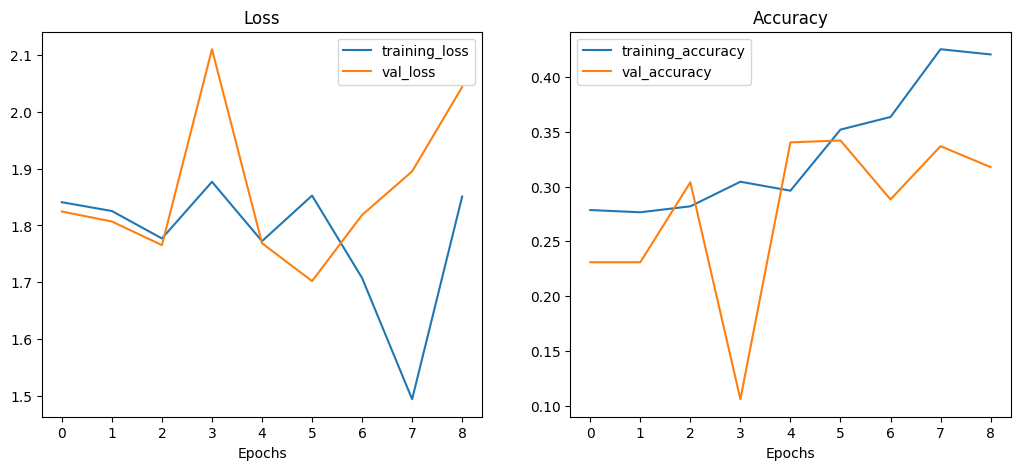

In [27]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}


inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(32, 2, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_5 = tf.keras.models.Model(inputs, outputs)

model_s_5.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_5 = model_s_5.fit(
    train_data_10_percent,
    epochs=10,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data,
    validation_steps=0.15 * len(validation_data),
    callbacks=get_callbacks('model_s_5', True),
)

model_s_5_preds = (tf.argmax(model_s_5.predict(validation_data), axis=1))
model_s_5_results = calculate_results(y_true=validation_labels, y_pred=model_s_5_preds)

plot_loss_curves(history_s_5)

model_s_5_results

### Model s 6

- Changing the params didn't work so trying out different params

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_6/20240121-173111
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_6/checkpoint.ckpt
Epoch 1/10


2024-01-21 17:31:11.867843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 43s 898ms/step - loss: 1.9055 - accuracy: 0.2772 - val_loss: 1.7902 - val_accuracy: 0.3038
Epoch 2/10
46/46 [==============================] - 40s 868ms/step - loss: 1.8077 - accuracy: 0.2935 - val_loss: 1.7878 - val_accuracy: 0.3056
Epoch 3/10
46/46 [==============================] - 41s 891ms/step - loss: 1.8033 - accuracy: 0.2948 - val_loss: 1.8543 - val_accuracy: 0.3142
Epoch 4/10
46/46 [==============================] - 41s 881ms/step - loss: 1.7639 - accuracy: 0.3050 - val_loss: 1.8068 - val_accuracy: 0.2726
Epoch 5/10
46/46 [==============================] - 40s 876ms/step - loss: 1.6637 - accuracy: 0.3553 - val_loss: 1.7388 - val_accuracy: 0.3281
Epoch 6/10
46/46 [==============================] - 40s 865ms/step - loss: 1.5930 - accuracy: 0.3832 - val_loss: 1.6240 - val_accuracy: 0.3715
Epoch 7/10
46/46 [==============================] - 41s 881ms/step - loss: 1.6360 - accuracy: 0.3621 - val_loss: 1.6991 - val_accuracy: 0.3194
Epoch 8/10

{'accuracy': 38.11854268624252,
 'precision': 0.41800982639598205,
 'recall': 0.38118542686242524,
 'f1': 0.3707595814020952}

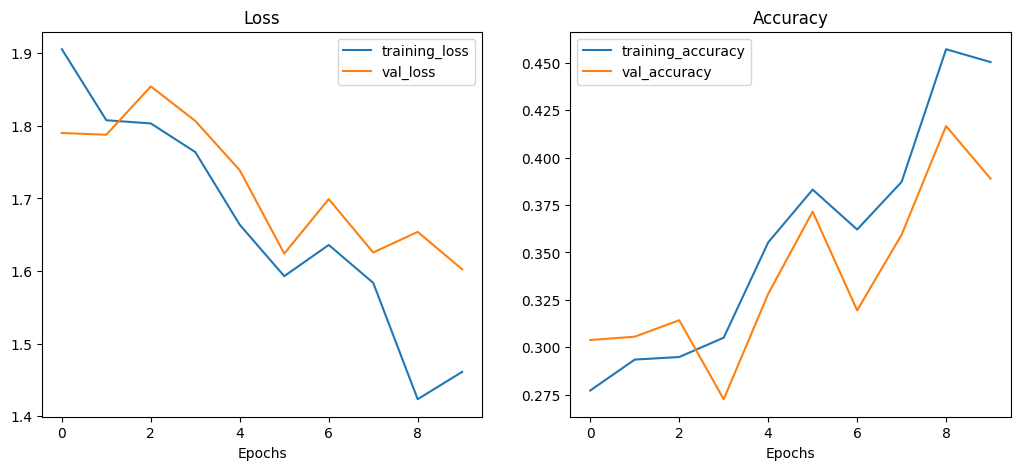

In [20]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}


inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_6 = tf.keras.models.Model(inputs, outputs)

model_s_6.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_6 = model_s_6.fit(
    train_data_10_percent,
    epochs=10,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data,
    validation_steps=0.15 * len(validation_data),
    callbacks=get_callbacks('model_s_6', True, 10),
)

model_s_6_preds = (tf.argmax(model_s_6.predict(validation_data), axis=1))
model_s_6_results = calculate_results(y_true=validation_labels, y_pred=model_s_6_preds)

plot_loss_curves(history_s_6)

model_s_6_results

### Model s 7 

- Reduced Overfitting a lot
-  Training for longer

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_7/20240121-174249
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_7/checkpoint.ckpt
Epoch 1/20
46/46 [==============================] - 42s 902ms/step - loss: 1.9456 - accuracy: 0.2629 - val_loss: 1.8764 - val_accuracy: 0.2592
Epoch 2/20
46/46 [==============================] - 38s 828ms/step - loss: 1.8427 - accuracy: 0.2609 - val_loss: 1.7922 - val_accuracy: 0.3033
Epoch 3/20
46/46 [==============================] - 39s 853ms/step - loss: 1.8155 - accuracy: 0.2908 - val_loss: 1.7931 - val_accuracy: 0.3033
Epoch 4/20
46/46 [==============================] - 40s 873ms/step - loss: 1.8124 - accuracy: 0.2833 - val_loss: 1.7816 - val_accuracy: 0.3033
Epoch 5/20
46/46 [==============================] - 40s 865ms/step - loss: 1.8090 - accuracy: 0.2853 - val_loss: 1.7716 - val_accuracy: 0.2537
Epoch 6/20
46/46 [==============================] - 40s 864ms/step - loss: 1.7523 - accuracy: 0.3118

{'accuracy': 37.656334964654704,
 'precision': 0.40935545311766564,
 'recall': 0.37656334964654703,
 'f1': 0.3714850299924404}

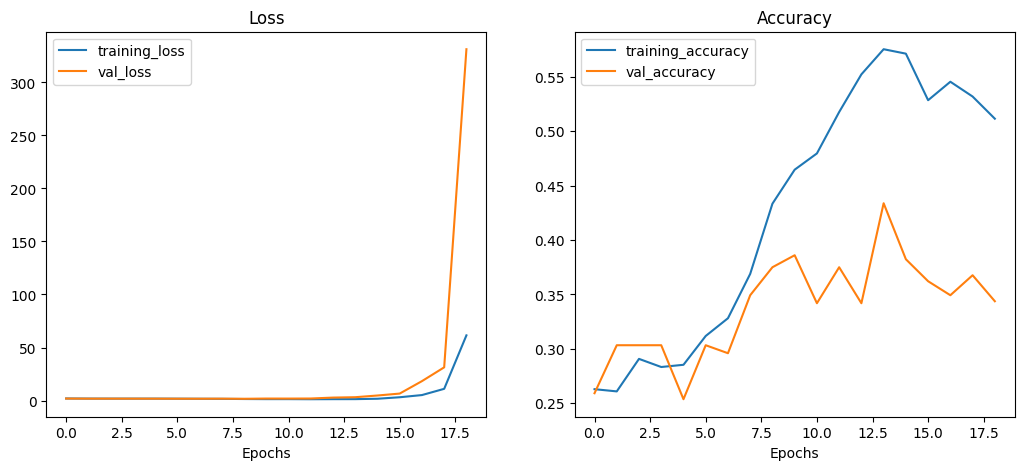

In [24]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}


inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_7 = tf.keras.models.Model(inputs, outputs)

model_s_7.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_7 = model_s_7.fit(
    train_data_10_percent,
    epochs=20,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data_15_percent,
    validation_steps=len(validation_data_15_percent),
    callbacks=get_callbacks('model_s_7', True, 10),
)

model_s_7_preds = (tf.argmax(model_s_7.predict(validation_data), axis=1))
model_s_7_results = calculate_results(y_true=validation_labels, y_pred=model_s_7_preds)

plot_loss_curves(history_s_7)

model_s_7_results

### Model s 8

- Changing params a little bit

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_8/20240121-175726
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_8/checkpoint.ckpt
Epoch 1/20
46/46 [==============================] - 219s 4s/step - loss: 2.2748 - accuracy: 0.2745 - val_loss: 1.8069 - val_accuracy: 0.3033
Epoch 2/20
46/46 [==============================] - 199s 4s/step - loss: 1.8517 - accuracy: 0.2751 - val_loss: 1.8865 - val_accuracy: 0.3033
Epoch 3/20
46/46 [==============================] - 201s 4s/step - loss: 1.8397 - accuracy: 0.2833 - val_loss: 1.7810 - val_accuracy: 0.3015
Epoch 4/20
46/46 [==============================] - 191s 4s/step - loss: 1.8350 - accuracy: 0.2724 - val_loss: 1.8111 - val_accuracy: 0.2298
Epoch 5/20
46/46 [==============================] - 189s 4s/step - loss: 1.8163 - accuracy: 0.2745 - val_loss: 1.8790 - val_accuracy: 0.3033
Epoch 6/20
46/46 [==============================] - 188s 4s/step - loss: 1.8479 - accuracy: 0.2955 - val_loss:

/Users/mufaddalhamid/Documents/Learn/TensorFlow/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 29.880369766177274,
 'precision': 0.14511576205072463,
 'recall': 0.2988036976617727,
 'f1': 0.15575612958354018}

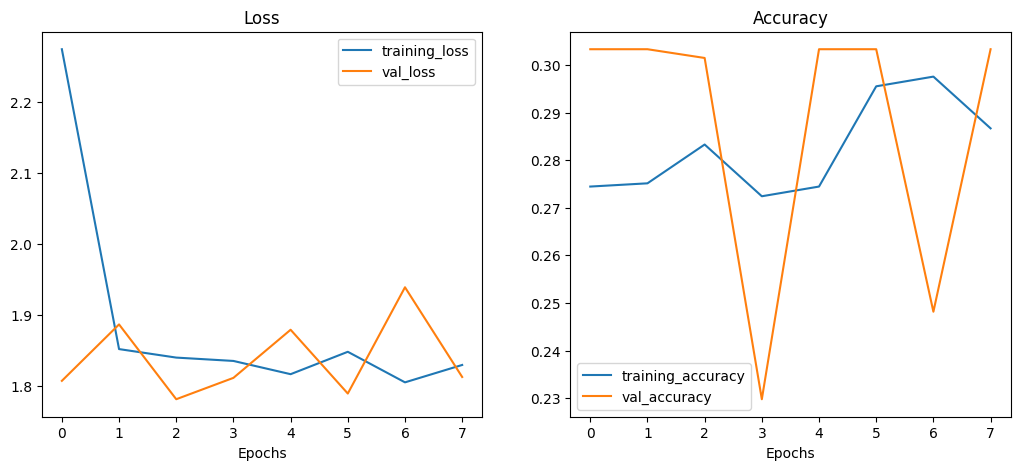

In [26]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}


inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(256, 12, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_8 = tf.keras.models.Model(inputs, outputs)

model_s_8.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_8 = model_s_8.fit(
    train_data_10_percent,
    epochs=20,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data_15_percent,
    validation_steps=len(validation_data_15_percent),
    callbacks=get_callbacks('model_s_8', True, 5),
)

model_s_8_preds = (tf.argmax(model_s_8.predict(validation_data), axis=1))
model_s_8_results = calculate_results(y_true=validation_labels, y_pred=model_s_8_preds)

plot_loss_curves(history_s_8)

model_s_8_results

### Model s 9

- No improvement but very long training time
- Changing param a bit more

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_9/20240121-183715
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_9/checkpoint.ckpt
Epoch 1/20
46/46 [==============================] - 69s 1s/step - loss: 2.1779 - accuracy: 0.2846 - val_loss: 1.8103 - val_accuracy: 0.2298
Epoch 2/20
46/46 [==============================] - 72s 2s/step - loss: 1.8217 - accuracy: 0.2860 - val_loss: 1.7924 - val_accuracy: 0.3033
Epoch 3/20
46/46 [==============================] - 70s 2s/step - loss: 1.8206 - accuracy: 0.2880 - val_loss: 1.7970 - val_accuracy: 0.3033
Epoch 4/20
46/46 [==============================] - 71s 2s/step - loss: 1.8245 - accuracy: 0.2874 - val_loss: 1.8011 - val_accuracy: 0.3033
Epoch 5/20
46/46 [==============================] - 71s 2s/step - loss: 1.8071 - accuracy: 0.2921 - val_loss: 1.7933 - val_accuracy: 0.3033
Epoch 6/20
46/46 [==============================] - 67s 1s/step - loss: 1.8159 - accuracy: 0.2928 - val_loss: 1.797

{'accuracy': 29.907558455682437,
 'precision': 0.28225227081820914,
 'recall': 0.29907558455682437,
 'f1': 0.2475226508109776}

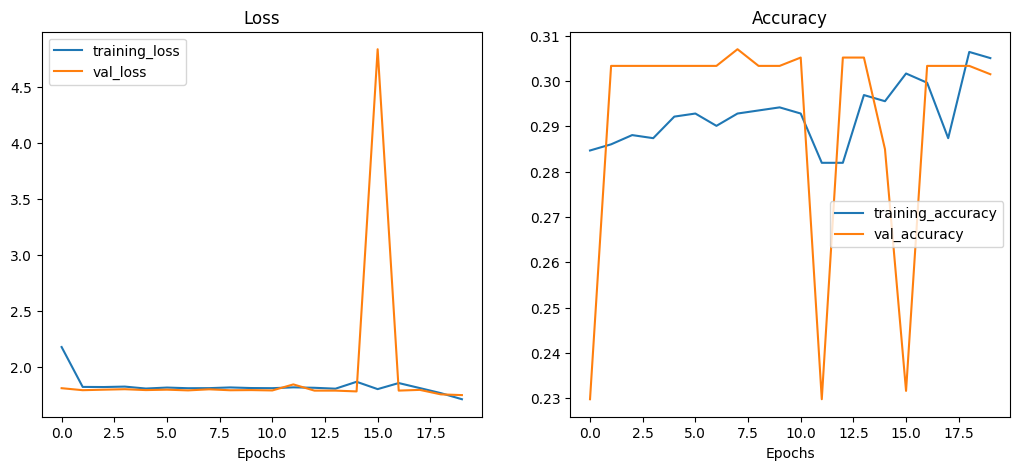

In [28]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}


inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_9 = tf.keras.models.Model(inputs, outputs)

model_s_9.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_9 = model_s_9.fit(
    train_data_10_percent,
    epochs=20,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data_15_percent,
    validation_steps=len(validation_data_15_percent),
    callbacks=get_callbacks('model_s_9', True, 10),
)

model_s_9_preds = (tf.argmax(model_s_9.predict(validation_data), axis=1))
model_s_9_results = calculate_results(y_true=validation_labels, y_pred=model_s_9_preds)

plot_loss_curves(history_s_9)

model_s_9_results

### Model s 10

- Changing param did not improve
- Reverting back
- Adding batch normalization layers

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_10/20240121-190111
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_10/checkpoint.ckpt
Epoch 1/10
46/46 [==============================] - 42s 881ms/step - loss: 4.6032 - accuracy: 0.2255 - val_loss: 11.3462 - val_accuracy: 0.1783
Epoch 2/10
46/46 [==============================] - 41s 886ms/step - loss: 3.6339 - accuracy: 0.2996 - val_loss: 14.5325 - val_accuracy: 0.0864
Epoch 3/10
46/46 [==============================] - 39s 851ms/step - loss: 3.4869 - accuracy: 0.3084 - val_loss: 5.5431 - val_accuracy: 0.2518
Epoch 4/10
46/46 [==============================] - 41s 887ms/step - loss: 4.0551 - accuracy: 0.3145 - val_loss: 13.3034 - val_accuracy: 0.1544
Epoch 5/10
46/46 [==============================] - 39s 857ms/step - loss: 3.6531 - accuracy: 0.3288 - val_loss: 8.7383 - val_accuracy: 0.1820
Epoch 6/10
46/46 [==============================] - 40s 864ms/step - loss: 3.2245 - accuracy: 0

{'accuracy': 24.71451876019576,
 'precision': 0.28587162488434065,
 'recall': 0.24714518760195758,
 'f1': 0.23620687908944196}

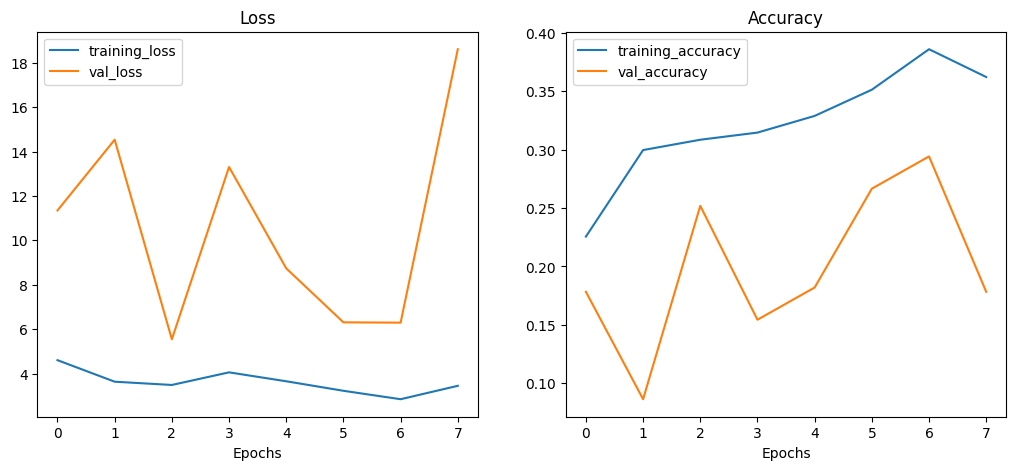

In [29]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_10 = tf.keras.models.Model(inputs, outputs)

model_s_10.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_10 = model_s_10.fit(
    train_data_10_percent,
    epochs=10,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data_15_percent,
    validation_steps=len(validation_data_15_percent),
    callbacks=get_callbacks('model_s_10', True, 5),
)

model_s_10_preds = tf.argmax(model_s_10.predict(validation_data), axis=1)
model_s_10_results = calculate_results(y_true=validation_labels, y_pred=model_s_10_preds)

plot_loss_curves(history_s_10)

model_s_10_results

### Model s 11

- Trying batch norm behind maxpool

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_11/20240121-190728
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_11/checkpoint.ckpt
Epoch 1/10
46/46 [==============================] - 49s 1s/step - loss: 4.9979 - accuracy: 0.2568 - val_loss: 80.4053 - val_accuracy: 0.3033
Epoch 2/10
46/46 [==============================] - 45s 975ms/step - loss: 4.4297 - accuracy: 0.2799 - val_loss: 22.9101 - val_accuracy: 0.3143
Epoch 3/10
46/46 [==============================] - 43s 942ms/step - loss: 4.7473 - accuracy: 0.2643 - val_loss: 8.3012 - val_accuracy: 0.2482
Epoch 4/10
46/46 [==============================] - 38s 817ms/step - loss: 4.2119 - accuracy: 0.2976 - val_loss: 7.5791 - val_accuracy: 0.2077
Epoch 5/10
46/46 [==============================] - 38s 829ms/step - loss: 3.7964 - accuracy: 0.3376 - val_loss: 9.9645 - val_accuracy: 0.1985
Epoch 6/10
46/46 [==============================] - 38s 821ms/step - loss: 3.1033 - accuracy: 0.373

{'accuracy': 28.656878738444806,
 'precision': 0.2938971215931728,
 'recall': 0.2865687873844481,
 'f1': 0.2706601995519012}

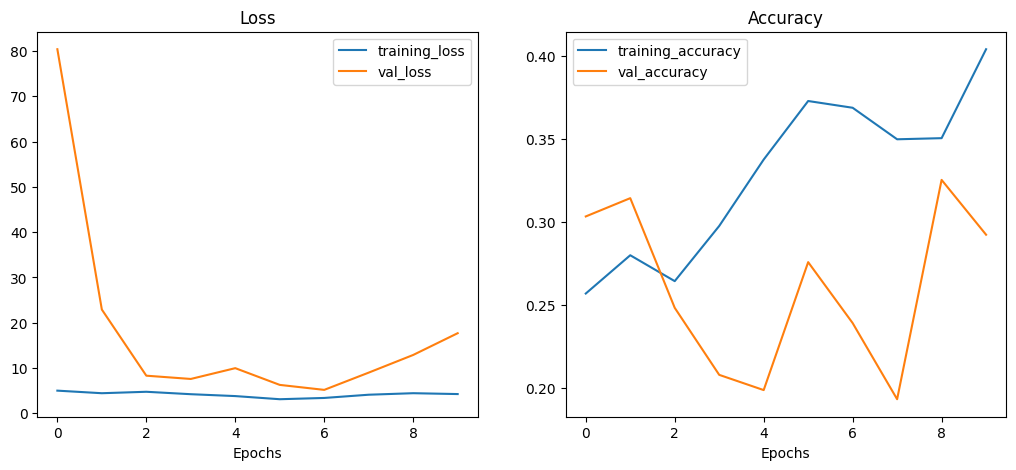

In [30]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_11 = tf.keras.models.Model(inputs, outputs)

model_s_11.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_11 = model_s_11.fit(
    train_data_10_percent,
    epochs=10,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data_15_percent,
    validation_steps=len(validation_data_15_percent),
    callbacks=get_callbacks('model_s_11', True, 5),
)

model_s_11_preds = tf.argmax(model_s_11.predict(validation_data), axis=1)
model_s_11_results = calculate_results(y_true=validation_labels, y_pred=model_s_11_preds)

plot_loss_curves(history_s_11)

model_s_11_results

### Model s 12

- Batch norm does not work
- Reverting back
- Adding another set of conv2d, maxpool

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_12/20240121-191631
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_12/checkpoint.ckpt
Epoch 1/10
46/46 [==============================] - 46s 963ms/step - loss: 1.8852 - accuracy: 0.2711 - val_loss: 1.8028 - val_accuracy: 0.2960
Epoch 2/10
46/46 [==============================] - 46s 988ms/step - loss: 1.8123 - accuracy: 0.2914 - val_loss: 1.7812 - val_accuracy: 0.3051
Epoch 3/10
46/46 [==============================] - 46s 986ms/step - loss: 1.7870 - accuracy: 0.3003 - val_loss: 1.7430 - val_accuracy: 0.3272
Epoch 4/10
46/46 [==============================] - 42s 900ms/step - loss: 1.8073 - accuracy: 0.2948 - val_loss: 1.7914 - val_accuracy: 0.2482
Epoch 5/10
46/46 [==============================] - 40s 865ms/step - loss: 1.7572 - accuracy: 0.2928 - val_loss: 1.7793 - val_accuracy: 0.3015
Epoch 6/10
46/46 [==============================] - 43s 929ms/step - loss: 1.6885 - accuracy: 0.36

{'accuracy': 40.97335508428493,
 'precision': 0.38510797347886316,
 'recall': 0.40973355084284935,
 'f1': 0.3601923632067298}

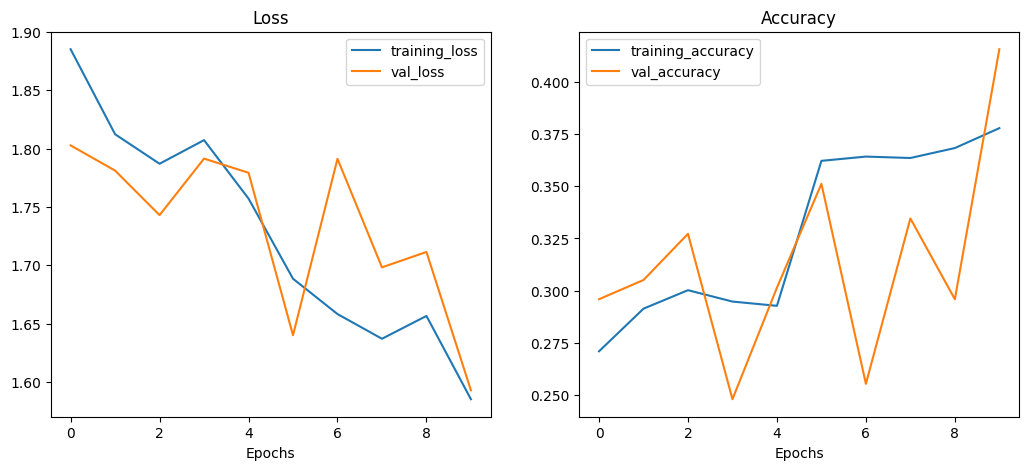

In [31]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_12 = tf.keras.models.Model(inputs, outputs)

model_s_12.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_12 = model_s_12.fit(
    train_data_10_percent,
    epochs=10,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data_15_percent,
    validation_steps=len(validation_data_15_percent),
    callbacks=get_callbacks('model_s_12', True, 5),
)

model_s_12_preds = tf.argmax(model_s_12.predict(validation_data), axis=1)
model_s_12_results = calculate_results(y_true=validation_labels, y_pred=model_s_12_preds)

plot_loss_curves(history_s_12)

model_s_12_results

### Model s 13

- I think last model, did that by chance so rerunnign similar model, but with 12 epochs

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_13/20240121-192905
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_13/checkpoint.ckpt
Epoch 1/12
46/46 [==============================] - 39s 838ms/step - loss: 1.8770 - accuracy: 0.2514 - val_loss: 1.7974 - val_accuracy: 0.3033
Epoch 2/12
46/46 [==============================] - 35s 756ms/step - loss: 1.8126 - accuracy: 0.2935 - val_loss: 1.7933 - val_accuracy: 0.3033
Epoch 3/12
46/46 [==============================] - 34s 745ms/step - loss: 1.8165 - accuracy: 0.2921 - val_loss: 1.7911 - val_accuracy: 0.2996
Epoch 4/12
46/46 [==============================] - 37s 793ms/step - loss: 1.7940 - accuracy: 0.2758 - val_loss: 1.7894 - val_accuracy: 0.2665
Epoch 5/12
46/46 [==============================] - 35s 762ms/step - loss: 1.7505 - accuracy: 0.3125 - val_loss: 1.7186 - val_accuracy: 0.3143
Epoch 6/12
46/46 [==============================] - 35s 759ms/step - loss: 1.7115 - accuracy: 0.32

{'accuracy': 39.99456226209897,
 'precision': 0.44308038554179946,
 'recall': 0.39994562262098965,
 'f1': 0.38218452285222826}

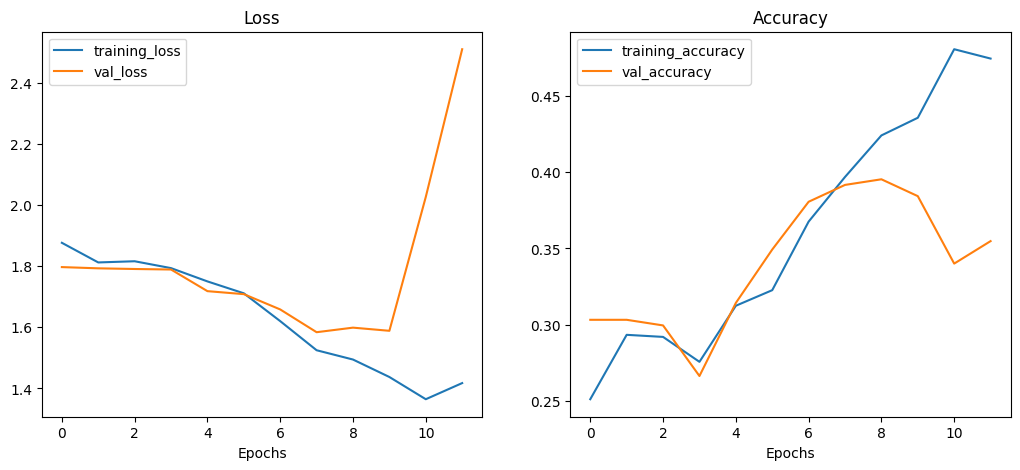

In [32]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_13 = tf.keras.models.Model(inputs, outputs)

model_s_13.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_13 = model_s_13.fit(
    train_data_10_percent,
    epochs=12,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data_15_percent,
    validation_steps=len(validation_data_15_percent),
    callbacks=get_callbacks('model_s_13', True, 5),
)

model_s_13_preds = tf.argmax(model_s_13.predict(validation_data), axis=1)
model_s_13_results = calculate_results(y_true=validation_labels, y_pred=model_s_13_preds)

plot_loss_curves(history_s_13)

model_s_13_results

### Model s 14

- Improved, adding a dense layer

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_14/20240121-195342
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_14/checkpoint.ckpt
Epoch 1/10
46/46 [==============================] - 40s 843ms/step - loss: 1.8479 - accuracy: 0.2609 - val_loss: 1.7980 - val_accuracy: 0.3033
Epoch 2/10
46/46 [==============================] - 38s 831ms/step - loss: 1.8289 - accuracy: 0.2880 - val_loss: 1.8005 - val_accuracy: 0.3033
Epoch 3/10
46/46 [==============================] - 38s 828ms/step - loss: 1.8216 - accuracy: 0.2901 - val_loss: 1.8023 - val_accuracy: 0.3033
Epoch 4/10
46/46 [==============================] - 38s 827ms/step - loss: 1.8127 - accuracy: 0.2908 - val_loss: 1.7964 - val_accuracy: 0.3033
Epoch 5/10
46/46 [==============================] - 39s 842ms/step - loss: 1.8006 - accuracy: 0.2982 - val_loss: 1.8050 - val_accuracy: 0.3033
Epoch 6/10
46/46 [==============================] - 39s 834ms/step - loss: 1.8102 - accuracy: 0.29

{'accuracy': 36.56878738444807,
 'precision': 0.3914905410773524,
 'recall': 0.3656878738444807,
 'f1': 0.32255096932364274}

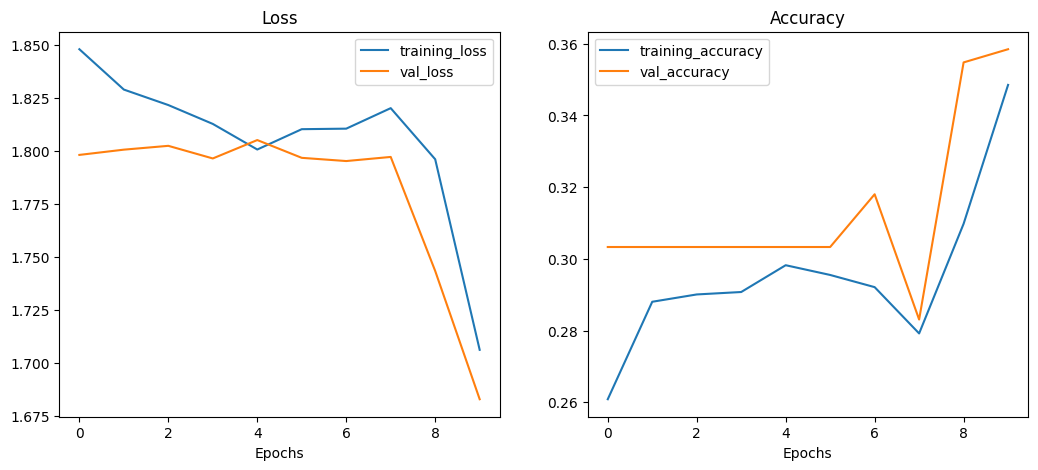

In [36]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_14 = tf.keras.models.Model(inputs, outputs)

model_s_14.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_14 = model_s_14.fit(
    train_data_10_percent,
    epochs=10,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data_15_percent,
    validation_steps=len(validation_data_15_percent),
    callbacks=get_callbacks('model_s_14', True, 5),
)

model_s_14_preds = tf.argmax(model_s_14.predict(validation_data), axis=1)
model_s_14_results = calculate_results(y_true=validation_labels, y_pred=model_s_14_preds)

plot_loss_curves(history_s_14)

model_s_14_results

### Model s 15

- Did not improve
- Trying best model with augmentation

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_15/20240121-201540
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_15/checkpoint.ckpt
Epoch 1/10
46/46 [==============================] - 45s 931ms/step - loss: 1.8427 - accuracy: 0.2867 - val_loss: 1.8110 - val_accuracy: 0.3033
Epoch 2/10
46/46 [==============================] - 46s 987ms/step - loss: 1.8269 - accuracy: 0.2908 - val_loss: 1.7954 - val_accuracy: 0.3033
Epoch 3/10
46/46 [==============================] - 44s 946ms/step - loss: 1.8130 - accuracy: 0.2948 - val_loss: 1.7911 - val_accuracy: 0.3033
Epoch 4/10
46/46 [==============================] - 47s 1s/step - loss: 1.8127 - accuracy: 0.2955 - val_loss: 1.8019 - val_accuracy: 0.3033
Epoch 5/10
46/46 [==============================] - 55s 1s/step - loss: 1.8143 - accuracy: 0.2894 - val_loss: 1.7950 - val_accuracy: 0.3033
Epoch 6/10
46/46 [==============================] - 40s 871ms/step - loss: 1.8127 - accuracy: 0.2887 - v

/Users/mufaddalhamid/Documents/Learn/TensorFlow/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 29.41816204458945,
 'precision': 0.08654282580817234,
 'recall': 0.2941816204458945,
 'f1': 0.13374139215229325}

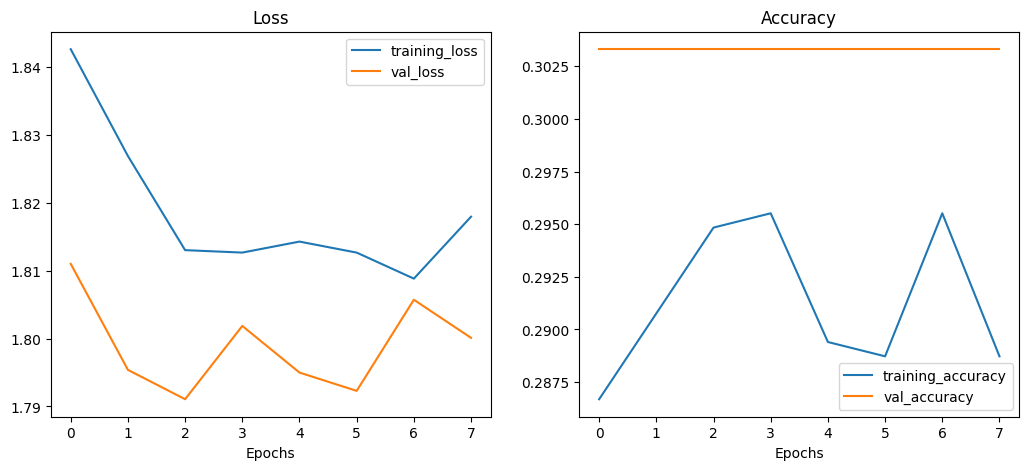

In [49]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.RandomZoom(0.2, 0.2)(x)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomTranslation(0.2, 0.2)(x)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_15 = tf.keras.models.Model(inputs, outputs)

model_s_15.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_15 = model_s_15.fit(
    train_data_10_percent,
    epochs=10,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data_15_percent,
    validation_steps=len(validation_data_15_percent),
    callbacks=get_callbacks('model_s_15', True, 5),
)

model_s_15_preds = tf.argmax(model_s_15.predict(validation_data), axis=1)
model_s_15_results = calculate_results(y_true=validation_labels, y_pred=model_s_15_preds)

plot_loss_curves(history_s_15)

model_s_15_results

### Count Each Class

In [179]:
def countEachClass(data):
    count = {}
    for label in data:
        if label not in count:
            count[label] = 1
        else:
            count[label] += 1
    countNew = {}
    for i in count:
        countNew[i] = f"{count[i]} ({round(count[i] / len(data) * 100, 2)}%)"
    keys = list(countNew.keys())
    keys.sort()
    sortedCount = {i: countNew[i] for i in keys}

    return sortedCount

In [180]:
val = {
    'model_s_6_preds': countEachClass(model_s_6_preds.numpy()),
    'model_s_7_preds': countEachClass(model_s_7_preds.numpy()),
    'model_s_8_preds': countEachClass(model_s_8_preds.numpy()),
    'model_s_9_preds': countEachClass(model_s_9_preds.numpy()),
    'model_s_10_preds': countEachClass(model_s_10_preds.numpy()),
    'model_s_11_preds': countEachClass(model_s_11_preds.numpy()),
    'model_s_12_preds': countEachClass(model_s_12_preds.numpy()),
    'model_s_13_preds': countEachClass(model_s_13_preds.numpy()),
    'model_s_14_preds': countEachClass(model_s_14_preds.numpy()),
    'model_s_15_preds': countEachClass(model_s_15_preds.numpy()),
}
val

{'model_s_6_preds': {0: '76 (2.07%)',
  1: '1285 (34.94%)',
  2: '375 (10.2%)',
  3: '530 (14.41%)',
  4: '923 (25.1%)',
  5: '258 (7.01%)',
  6: '231 (6.28%)'},
 'model_s_7_preds': {0: '179 (4.87%)',
  1: '641 (17.43%)',
  2: '1252 (34.04%)',
  3: '367 (9.98%)',
  4: '390 (10.6%)',
  5: '636 (17.29%)',
  6: '213 (5.79%)'},
 'model_s_8_preds': {1: '3498 (95.11%)', 2: '180 (4.89%)'},
 'model_s_9_preds': {0: '24 (0.65%)',
  1: '2114 (57.48%)',
  2: '545 (14.82%)',
  3: '365 (9.92%)',
  4: '18 (0.49%)',
  5: '35 (0.95%)',
  6: '577 (15.69%)'},
 'model_s_10_preds': {0: '371 (10.09%)',
  1: '427 (11.61%)',
  2: '1126 (30.61%)',
  3: '296 (8.05%)',
  4: '1150 (31.27%)',
  5: '102 (2.77%)',
  6: '206 (5.6%)'},
 'model_s_11_preds': {0: '164 (4.46%)',
  1: '928 (25.23%)',
  2: '647 (17.59%)',
  3: '366 (9.95%)',
  4: '60 (1.63%)',
  5: '208 (5.66%)',
  6: '1305 (35.48%)'},
 'model_s_12_preds': {0: '14 (0.38%)',
  1: '1578 (42.9%)',
  2: '1265 (34.39%)',
  3: '459 (12.48%)',
  4: '1 (0.03%)',
  

### Model s 16

- Training for longer


Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_16/20240121-203239
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_16/checkpoint.ckpt
Epoch 1/30
46/46 [==============================] - 47s 972ms/step - loss: 1.8591 - accuracy: 0.2561 - val_loss: 1.8230 - val_accuracy: 0.3033
Epoch 2/30
46/46 [==============================] - 41s 881ms/step - loss: 1.8288 - accuracy: 0.2928 - val_loss: 1.8047 - val_accuracy: 0.3033
Epoch 3/30
46/46 [==============================] - 43s 942ms/step - loss: 1.8194 - accuracy: 0.2921 - val_loss: 1.8078 - val_accuracy: 0.3033
Epoch 4/30
46/46 [==============================] - 45s 966ms/step - loss: 1.8011 - accuracy: 0.2976 - val_loss: 1.8044 - val_accuracy: 0.3033
Epoch 5/30
46/46 [==============================] - 41s 896ms/step - loss: 1.8167 - accuracy: 0.2887 - val_loss: 1.7967 - val_accuracy: 0.3033
Epoch 6/30
46/46 [==============================] - 43s 927ms/step - loss: 1.8166 - accuracy: 0.29

/Users/mufaddalhamid/Documents/Learn/TensorFlow/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 29.41816204458945,
 'precision': 0.08654282580817234,
 'recall': 0.2941816204458945,
 'f1': 0.13374139215229325}

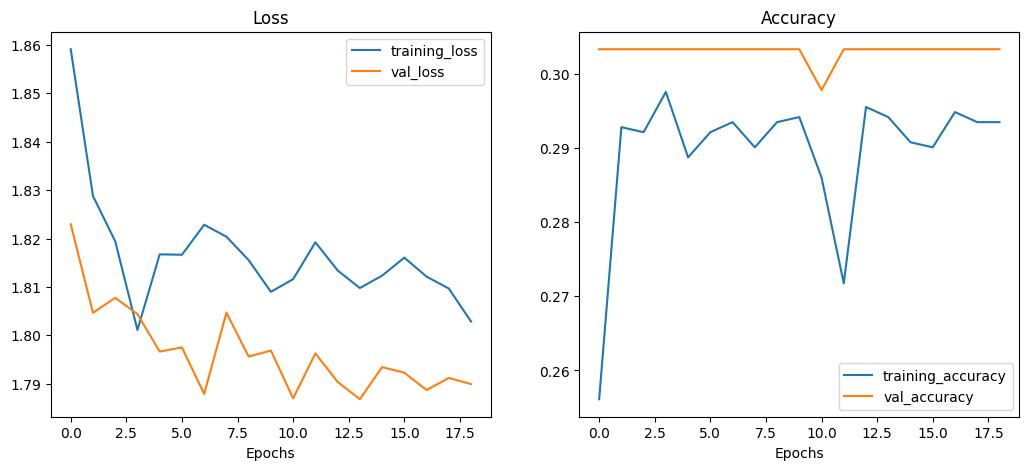

In [84]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.RandomZoom(0.2, 0.2)(x)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomTranslation(0.2, 0.2)(x)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_16 = tf.keras.models.Model(inputs, outputs)

model_s_16.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_16 = model_s_16.fit(
    train_data_10_percent,
    epochs=30,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data_15_percent,
    validation_steps=len(validation_data_15_percent),
    callbacks=get_callbacks('model_s_16', True, 5),
)

model_s_16_preds = tf.argmax(model_s_16.predict(validation_data), axis=1)
model_s_16_results = calculate_results(y_true=validation_labels, y_pred=model_s_16_preds)

plot_loss_curves(history_s_16)

print(countEachClass(model_s_16_preds.numpy()))

model_s_16_results

### Model s 17

- It is only predicting one class
- So trying to remove the translation in data augmentation

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_17/20240121-204910
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_17/checkpoint.ckpt
Epoch 1/20
46/46 [==============================] - 81s 2s/step - loss: 1.8444 - accuracy: 0.2711 - val_loss: 1.8350 - val_accuracy: 0.3033
Epoch 2/20
46/46 [==============================] - 56s 1s/step - loss: 1.8170 - accuracy: 0.2928 - val_loss: 1.8295 - val_accuracy: 0.3033
Epoch 3/20
46/46 [==============================] - 48s 1s/step - loss: 1.8133 - accuracy: 0.2955 - val_loss: 1.7864 - val_accuracy: 0.3033
Epoch 4/20
46/46 [==============================] - 54s 1s/step - loss: 1.8081 - accuracy: 0.2935 - val_loss: 1.7994 - val_accuracy: 0.3033
Epoch 5/20
46/46 [==============================] - 54s 1s/step - loss: 1.8195 - accuracy: 0.2914 - val_loss: 1.8157 - val_accuracy: 0.3033
Epoch 6/20
46/46 [==============================] - 56s 1s/step - loss: 1.8070 - accuracy: 0.2914 - val_loss: 1.8

/Users/mufaddalhamid/Documents/Learn/TensorFlow/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 37.19412724306688,
 'precision': 0.3186054004901072,
 'recall': 0.3719412724306688,
 'f1': 0.3136779539767239}

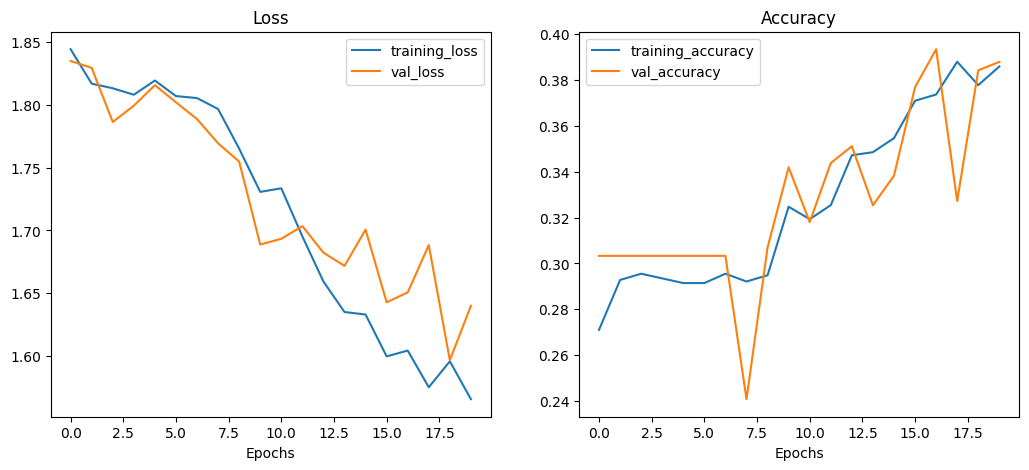

In [86]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.RandomZoom(0.2, 0.2)(x)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_17 = tf.keras.models.Model(inputs, outputs)

model_s_17.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_17 = model_s_17.fit(
    train_data_10_percent,
    epochs=20,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data_15_percent,
    validation_steps=len(validation_data_15_percent),
    callbacks=get_callbacks('model_s_17', True, 5),
)

model_s_17_preds = tf.argmax(model_s_17.predict(validation_data), axis=1)
model_s_17_results = calculate_results(y_true=validation_labels, y_pred=model_s_17_preds)

plot_loss_curves(history_s_17)

print(countEachClass(model_s_17_preds.numpy()))

model_s_17_results

### Trying out data augmentation - 


2024-01-21 21:12:06.242443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


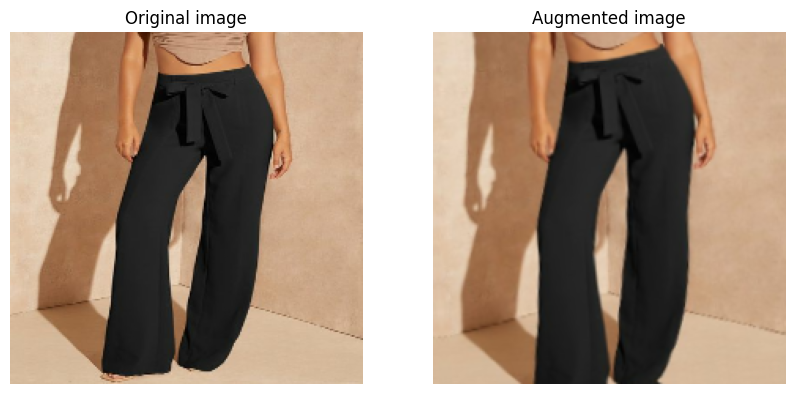

In [134]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1/255.),
    tf.keras.layers.RandomZoom(0.1, 0.1),
    tf.keras.layers.RandomRotation(0.03),
    tf.keras.layers.RandomFlip("horizontal"),
])

for random_data, _ in train_data_10_percent.take(1):
    plt.figure(figsize=(10, 7))
    plt.subplot(1, 2, 1)
    plt.title(f"Original image")
    plt.imshow(random_data[0]/255.)
    plt.axis(False)
    plt.subplot(1, 2, 2)
    plt.title(f"Augmented image")
    plt.imshow(data_augmentation(tf.expand_dims(random_data[0], axis=0))[0])
    plt.axis(False)
    plt.show()


### Model s 18

- As seen, the randomness was too much so changing it to the best what i found

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_18/20240121-211247
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_18/checkpoint.ckpt
Epoch 1/10
46/46 [==============================] - 47s 968ms/step - loss: 1.8580 - accuracy: 0.2663 - val_loss: 1.7952 - val_accuracy: 0.3033
Epoch 2/10
46/46 [==============================] - 44s 942ms/step - loss: 1.8117 - accuracy: 0.2914 - val_loss: 1.7948 - val_accuracy: 0.3033
Epoch 3/10
46/46 [==============================] - 44s 960ms/step - loss: 1.8110 - accuracy: 0.2935 - val_loss: 1.7923 - val_accuracy: 0.3033
Epoch 4/10
46/46 [==============================] - 45s 973ms/step - loss: 1.7940 - accuracy: 0.2969 - val_loss: 1.7552 - val_accuracy: 0.3051
Epoch 5/10
46/46 [==============================] - 47s 1s/step - loss: 1.7826 - accuracy: 0.2901 - val_loss: 1.8528 - val_accuracy: 0.2390
Epoch 6/10
46/46 [==============================] - 42s 912ms/step - loss: 1.7657 - accuracy: 0.3030 

{'accuracy': 42.25122349102774,
 'precision': 0.4291250389069601,
 'recall': 0.42251223491027734,
 'f1': 0.3986605957740402}

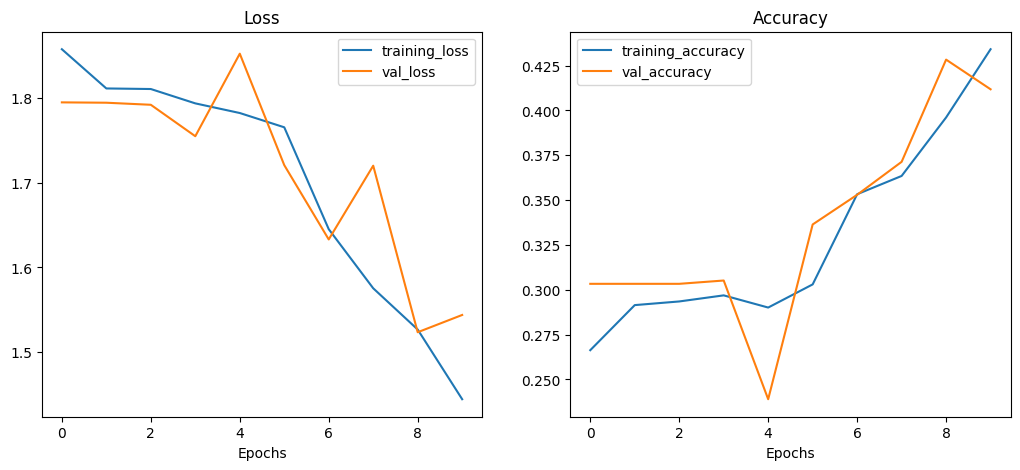

In [135]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.RandomZoom(0.1, 0.1)(x)
x = tf.keras.layers.RandomRotation(0.03)(x)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_18 = tf.keras.models.Model(inputs, outputs)

model_s_18.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_18 = model_s_18.fit(
    train_data_10_percent,
    epochs=10,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data_15_percent,
    validation_steps=len(validation_data_15_percent),
    callbacks=get_callbacks('model_s_18', True, 5),
)

model_s_18_preds = tf.argmax(model_s_18.predict(validation_data), axis=1)
model_s_18_results = calculate_results(y_true=validation_labels, y_pred=model_s_18_preds)

plot_loss_curves(history_s_18)

print(countEachClass(model_s_18_preds.numpy()))

model_s_18_results

### Model s 19

- Pretty good, not overfitting at all, trying to increase epochs and training

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_19/20240121-214957
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_19/checkpoint.ckpt
Epoch 1/30
46/46 [==============================] - 42s 878ms/step - loss: 1.8581 - accuracy: 0.2792 - val_loss: 1.7848 - val_accuracy: 0.3033
Epoch 2/30
46/46 [==============================] - 40s 860ms/step - loss: 1.8246 - accuracy: 0.2982 - val_loss: 1.7882 - val_accuracy: 0.3015
Epoch 3/30
46/46 [==============================] - 40s 860ms/step - loss: 1.8095 - accuracy: 0.2908 - val_loss: 1.7806 - val_accuracy: 0.3033
Epoch 4/30
46/46 [==============================] - 39s 856ms/step - loss: 1.7947 - accuracy: 0.2921 - val_loss: 1.7912 - val_accuracy: 0.2849
Epoch 5/30
46/46 [==============================] - 39s 856ms/step - loss: 1.7604 - accuracy: 0.2901 - val_loss: 1.7724 - val_accuracy: 0.2868
Epoch 6/30
46/46 [==============================] - 40s 860ms/step - loss: 1.6806 - accuracy: 0.32

{'accuracy': 41.73463839042958,
 'precision': 0.44950500819240846,
 'recall': 0.4173463839042958,
 'f1': 0.3784015209831874}

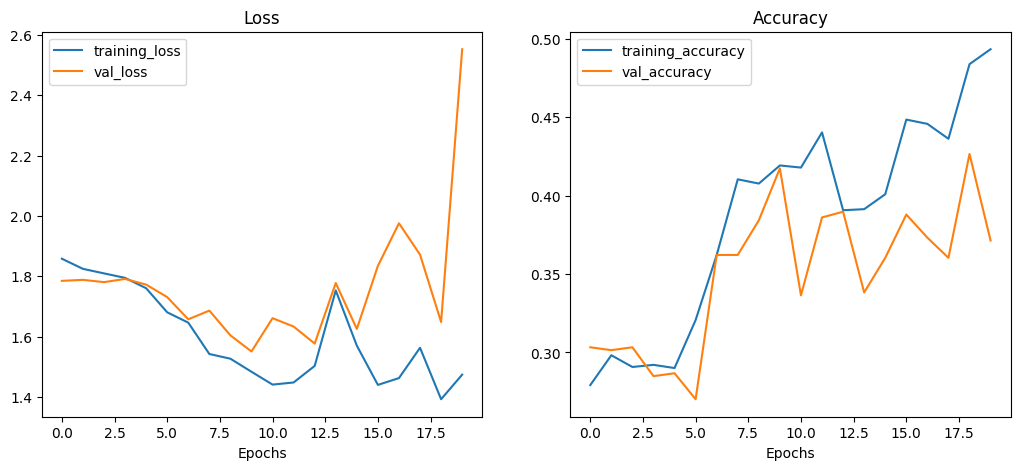

In [139]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.RandomZoom(0.1, 0.1)(x)
x = tf.keras.layers.RandomRotation(0.03)(x)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_19 = tf.keras.models.Model(inputs, outputs)

model_s_19.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_s_19 = model_s_19.fit(
    train_data_10_percent,
    epochs=30,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data_15_percent,
    validation_steps=len(validation_data_15_percent),
    callbacks=get_callbacks('model_s_19', True, 10),
)

model_s_19_preds = tf.argmax(model_s_19.predict(validation_data), axis=1)
model_s_19_results = calculate_results(y_true=validation_labels, y_pred=model_s_19_preds)

plot_loss_curves(history_s_19)

print(countEachClass(model_s_19_preds.numpy()))

model_s_19_results

### Model s 20

- Trying out SGD

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_s_20/20240121-220335
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_s_20/checkpoint.ckpt
Epoch 1/30
46/46 [==============================] - 45s 846ms/step - loss: 1.8483 - accuracy: 0.2670 - val_loss: 1.7896 - val_accuracy: 0.2960
Epoch 2/30
46/46 [==============================] - 38s 831ms/step - loss: 1.8016 - accuracy: 0.2867 - val_loss: 1.7884 - val_accuracy: 0.3051
Epoch 3/30
46/46 [==============================] - 41s 902ms/step - loss: 1.7814 - accuracy: 0.2955 - val_loss: 1.7690 - val_accuracy: 0.3051
Epoch 4/30
46/46 [==============================] - 41s 886ms/step - loss: 1.7757 - accuracy: 0.3064 - val_loss: 1.7677 - val_accuracy: 0.3309
Epoch 5/30
46/46 [==============================] - 40s 861ms/step - loss: 1.7512 - accuracy: 0.3050 - val_loss: 1.7422 - val_accuracy: 0.3566
Epoch 6/30
46/46 [==============================] - 41s 883ms/step - loss: 1.7449 - accuracy: 0.31

{'accuracy': 41.29961935834693,
 'precision': 0.4429521880066066,
 'recall': 0.4129961935834693,
 'f1': 0.38615214842530826}

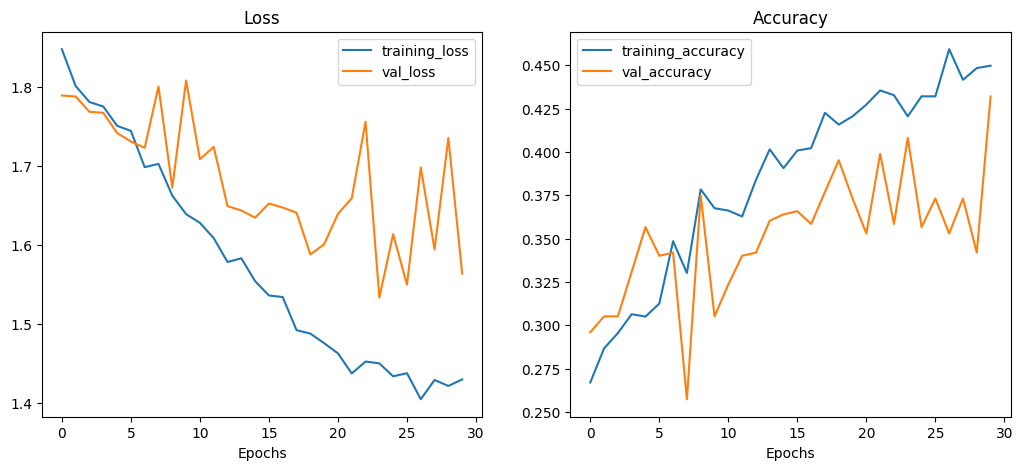

In [140]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.RandomZoom(0.1, 0.1)(x)
x = tf.keras.layers.RandomRotation(0.03)(x)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_s_20 = tf.keras.models.Model(inputs, outputs)

model_s_20.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.SGD(),
    metrics=['accuracy'],
)

history_s_20 = model_s_20.fit(
    train_data_10_percent,
    epochs=30,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data_15_percent,
    validation_steps=len(validation_data_15_percent),
    callbacks=get_callbacks('model_s_20', True, 10),
)

model_s_20_preds = tf.argmax(model_s_20.predict(validation_data), axis=1)
model_s_20_results = calculate_results(y_true=validation_labels, y_pred=model_s_20_preds)

plot_loss_curves(history_s_20)

print(countEachClass(model_s_20_preds.numpy()))

model_s_20_results

### Testing on more data

In [162]:
val = {
    'model_s_6_preds': countEachClass(model_s_6_preds.numpy()),
    'model_s_7_preds': countEachClass(model_s_7_preds.numpy()),
    'model_s_8_preds': countEachClass(model_s_8_preds.numpy()),
    'model_s_9_preds': countEachClass(model_s_9_preds.numpy()),
    'model_s_10_preds': countEachClass(model_s_10_preds.numpy()),
    'model_s_11_preds': countEachClass(model_s_11_preds.numpy()),
    'model_s_12_preds': countEachClass(model_s_12_preds.numpy()),
    'model_s_13_preds': countEachClass(model_s_13_preds.numpy()),
    'model_s_14_preds': countEachClass(model_s_14_preds.numpy()),
    'model_s_15_preds': countEachClass(model_s_15_preds.numpy()),
    'model_s_16_preds': countEachClass(model_s_16_preds.numpy()),
    'model_s_17_preds': countEachClass(model_s_17_preds.numpy()),
    'model_s_18_preds': countEachClass(model_s_18_preds.numpy()),
    'model_s_19_preds': countEachClass(model_s_19_preds.numpy()),
    'model_s_20_preds': countEachClass(model_s_20_preds.numpy()),
    
}
val

{'model_s_6_preds': {4: '923 (25.1%)',
  3: '530 (14.41%)',
  1: '1285 (34.94%)',
  2: '375 (10.2%)',
  6: '231 (6.28%)',
  0: '76 (2.07%)',
  5: '258 (7.01%)'},
 'model_s_7_preds': {4: '390 (10.6%)',
  2: '1252 (34.04%)',
  6: '213 (5.79%)',
  3: '367 (9.98%)',
  5: '636 (17.29%)',
  1: '641 (17.43%)',
  0: '179 (4.87%)'},
 'model_s_8_preds': {1: '3498 (95.11%)', 2: '180 (4.89%)'},
 'model_s_9_preds': {1: '2114 (57.48%)',
  3: '365 (9.92%)',
  2: '545 (14.82%)',
  6: '577 (15.69%)',
  4: '18 (0.49%)',
  0: '24 (0.65%)',
  5: '35 (0.95%)'},
 'model_s_10_preds': {4: '1150 (31.27%)',
  0: '371 (10.09%)',
  1: '427 (11.61%)',
  5: '102 (2.77%)',
  3: '296 (8.05%)',
  2: '1126 (30.61%)',
  6: '206 (5.6%)'},
 'model_s_11_preds': {6: '1305 (35.48%)',
  1: '928 (25.23%)',
  0: '164 (4.46%)',
  3: '366 (9.95%)',
  2: '647 (17.59%)',
  5: '208 (5.66%)',
  4: '60 (1.63%)'},
 'model_s_12_preds': {1: '1578 (42.9%)',
  6: '311 (8.46%)',
  2: '1265 (34.39%)',
  3: '459 (12.48%)',
  5: '50 (1.36%)',


In [150]:
model_s_7_all_preds = tf.argmax(model_s_7.predict(all_data), axis=1)
model_s_7_all_results = calculate_results(y_true=all_data_labels, y_pred=model_s_7_all_preds)

model_s_7_all_results

575/575 [==============================] - 97s 168ms/step


{'accuracy': 17.23125441792181,
 'precision': 0.182574672526692,
 'recall': 0.1723125441792181,
 'f1': 0.16770309520076435}

In [151]:
model_s_11_all_preds = tf.argmax(model_s_11.predict(all_data), axis=1)
model_s_11_all_results = calculate_results(y_true=all_data_labels, y_pred=model_s_11_all_preds)

model_s_11_all_results

575/575 [==============================] - 104s 180ms/step


{'accuracy': 17.14425534228699,
 'precision': 0.18333511939624483,
 'recall': 0.17144255342286988,
 'f1': 0.16557659703229569}

In [152]:
model_s_12_all_preds = tf.argmax(model_s_12.predict(all_data), axis=1)
model_s_12_all_results = calculate_results(y_true=all_data_labels, y_pred=model_s_12_all_preds)

model_s_12_all_results

575/575 [==============================] - 91s 159ms/step


{'accuracy': 22.815507585231906,
 'precision': 0.17126304692903763,
 'recall': 0.22815507585231906,
 'f1': 0.1888260966103915}

In [153]:
model_s_13_all_preds = tf.argmax(model_s_13.predict(all_data), axis=1)
model_s_13_all_results = calculate_results(y_true=all_data_labels, y_pred=model_s_13_all_preds)

model_s_13_all_results

575/575 [==============================] - 91s 158ms/step


{'accuracy': 21.869392637703225,
 'precision': 0.17952218950794652,
 'recall': 0.21869392637703225,
 'f1': 0.18704722094466036}

In [154]:
model_s_14_all_preds = tf.argmax(model_s_14.predict(all_data), axis=1)
model_s_14_all_results = calculate_results(y_true=all_data_labels, y_pred=model_s_14_all_preds)

model_s_14_all_results

575/575 [==============================] - 91s 158ms/step


{'accuracy': 24.02805720189223,
 'precision': 0.18337444805170605,
 'recall': 0.2402805720189223,
 'f1': 0.19475235787731432}

In [155]:
model_s_15_all_preds = tf.argmax(model_s_15.predict(all_data), axis=1)
model_s_15_all_results = calculate_results(y_true=all_data_labels, y_pred=model_s_15_all_preds)

model_s_15_all_results

575/575 [==============================] - 92s 158ms/step


/Users/mufaddalhamid/Documents/Learn/TensorFlow/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 22.20651405578816,
 'precision': 0.06676206861399459,
 'recall': 0.22206514055788157,
 'f1': 0.08081444760396883}

In [156]:
model_s_16_all_preds = tf.argmax(model_s_16.predict(all_data), axis=1)
model_s_16_all_results = calculate_results(y_true=all_data_labels, y_pred=model_s_16_all_preds)

model_s_16_all_results

575/575 [==============================] - 93s 161ms/step


/Users/mufaddalhamid/Documents/Learn/TensorFlow/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 29.275188951117393,
 'precision': 0.08570366881236259,
 'recall': 0.2927518895111739,
 'f1': 0.13259105557334683}

In [157]:
model_s_17_all_preds = tf.argmax(model_s_17.predict(all_data), axis=1)
model_s_17_all_results = calculate_results(y_true=all_data_labels, y_pred=model_s_17_all_preds)

model_s_17_all_results

575/575 [==============================] - 94s 162ms/step


{'accuracy': 21.320210972758414,
 'precision': 0.16927520440873567,
 'recall': 0.21320210972758413,
 'f1': 0.1787160341276164}

In [149]:
model_s_18_all_preds = tf.argmax(model_s_18.predict(all_data), axis=1)
model_s_18_all_results = calculate_results(y_true=all_data_labels, y_pred=model_s_18_all_preds)

model_s_18_all_results

575/575 [==============================] - 94s 163ms/step


{'accuracy': 21.738894024250992,
 'precision': 0.18107920333577582,
 'recall': 0.21738894024250993,
 'f1': 0.18945493133335528}

In [145]:
model_s_19_all_preds = tf.argmax(model_s_19.predict(all_data), axis=1)
model_s_19_all_results = calculate_results(y_true=all_data_labels, y_pred=model_s_19_all_preds)

model_s_19_all_results

575/575 [==============================] - 92s 161ms/step


{'accuracy': 23.652873688217063,
 'precision': 0.1814867667481051,
 'recall': 0.23652873688217063,
 'f1': 0.18822773960911154}

In [146]:
model_s_20_all_preds = tf.argmax(model_s_20.predict(all_data), axis=1)
model_s_20_all_results = calculate_results(y_true=all_data_labels, y_pred=model_s_20_all_preds)

model_s_20_all_results

  1/575 [..............................] - ETA: 2:56

575/575 [==============================] - 91s 158ms/step


{'accuracy': 21.178837474851832,
 'precision': 0.18165905155440557,
 'recall': 0.2117883747485183,
 'f1': 0.18816909173133112}

## So Trying by fitting the best few models on all data

In [164]:
all_model_all_results = pd.DataFrame(
    {
        "7_all": model_s_7_all_results,
        "11_all": model_s_11_all_results,
        "12_all": model_s_12_all_results,
        "13_all": model_s_13_all_results,
        "14_all": model_s_14_all_results,
        "15_all": model_s_15_all_results,
        "16_all": model_s_16_all_results,
        "17_all": model_s_17_all_results,
        "18_all": model_s_18_all_results,
        "19_all": model_s_19_all_results,
        "20_all": model_s_20_all_results,
    }
).transpose()
all_model_all_results["accuracy"] = all_model_all_results["accuracy"] / 100
all_model_all_results = all_model_all_results.sort_values("accuracy", ascending=False)
all_model_all_results

,accuracy,precision,recall,f1
16_all,0.292752,0.085704,0.292752,0.132591
14_all,0.240281,0.183374,0.240281,0.194752
19_all,0.236529,0.181487,0.236529,0.188228
12_all,0.228155,0.171263,0.228155,0.188826
15_all,0.222065,0.066762,0.222065,0.080814
13_all,0.218694,0.179522,0.218694,0.187047
18_all,0.217389,0.181079,0.217389,0.189455
17_all,0.213202,0.169275,0.213202,0.178716
20_all,0.211788,0.181659,0.211788,0.188169
7_all,0.172313,0.182575,0.172313,0.167703


In [165]:
all_model_results = pd.DataFrame(
    {
        "s_6": model_s_6_results,
        "s_7": model_s_7_results,
        "s_8": model_s_8_results,
        "s_9": model_s_9_results,
        "s_10": model_s_10_results,
        "s_11": model_s_11_results,
        "s_12": model_s_12_results,
        "s_13": model_s_13_results,
        "s_14": model_s_14_results,
        "s_15": model_s_15_results,
        "s_16": model_s_16_results,
        "s_17": model_s_17_results,
        "s_18": model_s_18_results,
        "s_19": model_s_19_results,
        "s_20": model_s_20_results,
                
    }
).transpose()
all_model_results["accuracy"] = all_model_results["accuracy"] / 100
all_model_results = all_model_results.sort_values("accuracy", ascending=False)
all_model_results

,accuracy,precision,recall,f1
s_18,0.422512,0.429125,0.422512,0.398661
s_19,0.417346,0.449505,0.417346,0.378402
s_20,0.412996,0.442952,0.412996,0.386152
s_12,0.409734,0.385108,0.409734,0.360192
s_13,0.399946,0.443080,0.399946,0.382185
s_6,0.381185,0.418010,0.381185,0.370760
s_7,0.376563,0.409355,0.376563,0.371485
s_17,0.371941,0.318605,0.371941,0.313678
s_14,0.365688,0.391491,0.365688,0.322551
s_9,0.299076,0.282252,0.299076,0.247523


In [166]:
all_model_results = pd.DataFrame(
    {
        "s_6": model_s_6_results,
        "s_7": model_s_7_results,
        "s_8": model_s_8_results,
        "s_9": model_s_9_results,
        "s_10": model_s_10_results,
        "s_11": model_s_11_results,
        "s_12": model_s_12_results,
        "s_13": model_s_13_results,
        "s_14": model_s_14_results,
        "s_15": model_s_15_results,
        "s_16": model_s_16_results,
        "s_17": model_s_17_results,
        "s_18": model_s_18_results,
        "s_19": model_s_19_results,
        "s_20": model_s_20_results,
                
    }
).transpose()
all_model_results["accuracy"] = all_model_results["accuracy"] / 100
all_model_results = all_model_results.sort_values("f1", ascending=False)
all_model_results

,accuracy,precision,recall,f1
s_18,0.422512,0.429125,0.422512,0.398661
s_20,0.412996,0.442952,0.412996,0.386152
s_13,0.399946,0.443080,0.399946,0.382185
s_19,0.417346,0.449505,0.417346,0.378402
s_7,0.376563,0.409355,0.376563,0.371485
s_6,0.381185,0.418010,0.381185,0.370760
s_12,0.409734,0.385108,0.409734,0.360192
s_14,0.365688,0.391491,0.365688,0.322551
s_17,0.371941,0.318605,0.371941,0.313678
s_11,0.286569,0.293897,0.286569,0.270660


### Trying out following models - 18,20,13,19,6,12,7,14

### Model 8 = Model s 18

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_8/20240122-011523
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_8/checkpoint.ckpt
Epoch 1/100
460/460 [==============================] - 369s 799ms/step - loss: 1.7822 - accuracy: 0.3023 - val_loss: 1.5900 - val_accuracy: 0.3692
Epoch 2/100
460/460 [==============================] - 370s 803ms/step - loss: 1.4803 - accuracy: 0.4190 - val_loss: 1.3582 - val_accuracy: 0.4891
Epoch 3/100
460/460 [==============================] - 366s 796ms/step - loss: 1.3462 - accuracy: 0.4688 - val_loss: 1.3402 - val_accuracy: 0.5198
Epoch 4/100
460/460 [==============================] - 376s 817ms/step - loss: 1.3327 - accuracy: 0.4834 - val_loss: 1.5482 - val_accuracy: 0.4674
Epoch 5/100
460/460 [==============================] - 387s 842ms/step - loss: 1.3888 - accuracy: 0.4760 - val_loss: 1.8357 - val_accuracy: 0.4744
Epoch 6/100
460/460 [==============================] - 380s 825ms/step - loss: 1.861

{'accuracy': 51.984774333877105,
 'precision': 0.5146918692697532,
 'recall': 0.519847743338771,
 'f1': 0.506329052142349}

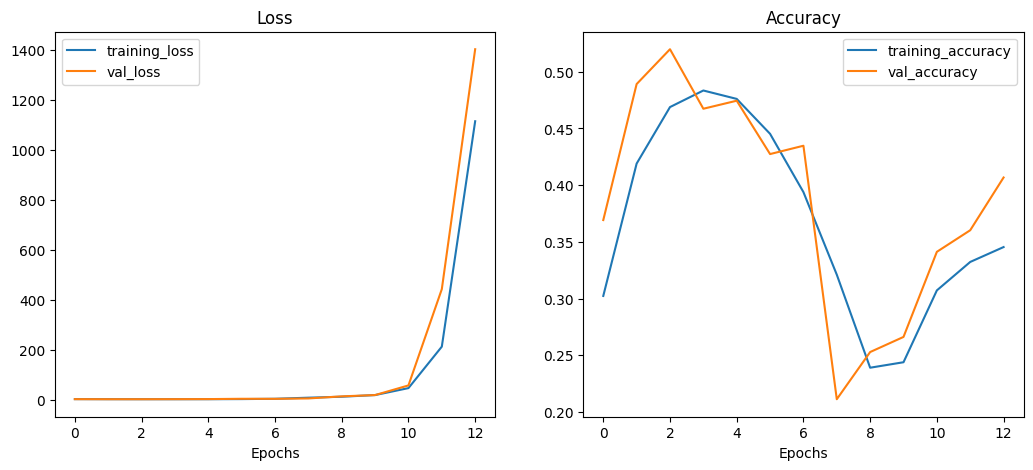

In [202]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.RandomZoom(0.1, 0.1)(x)
x = tf.keras.layers.RandomRotation(0.03)(x)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_8 = tf.keras.models.Model(inputs, outputs)

model_8.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_8 = model_8.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=get_callbacks('model_8', True, 10),
)

model_8_preds = tf.argmax(model_8.predict(validation_data), axis=1)
model_8_results = calculate_results(y_true=validation_labels, y_pred=model_8_preds)

plot_loss_curves(history_8)

print(countEachClass(model_8_preds.numpy()))
print(model_8.evaluate(validation_data))

model_8_results

In [203]:
from time import sleep
# Sleep for 5 minutes 
sleep(60 * 5)

### Model 9 = Model s 20

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_9/20240122-024254
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_9/checkpoint.ckpt
Epoch 1/100
460/460 [==============================] - 387s 839ms/step - loss: 1.7992 - accuracy: 0.2976 - val_loss: 1.7713 - val_accuracy: 0.2939
Epoch 2/100
460/460 [==============================] - 418s 909ms/step - loss: 1.6704 - accuracy: 0.3445 - val_loss: 1.6215 - val_accuracy: 0.3907
Epoch 3/100
460/460 [==============================] - 386s 838ms/step - loss: 1.5501 - accuracy: 0.3943 - val_loss: 1.5021 - val_accuracy: 0.4209
Epoch 4/100
460/460 [==============================] - 400s 870ms/step - loss: 1.4954 - accuracy: 0.4170 - val_loss: 1.4153 - val_accuracy: 0.4652
Epoch 5/100
460/460 [==============================] - 407s 884ms/step - loss: 1.4458 - accuracy: 0.4364 - val_loss: 1.3962 - val_accuracy: 0.4791
Epoch 6/100
460/460 [==============================] - 388s 844ms/step - loss: 1.405

{'accuracy': 47.90647090810223,
 'precision': 0.4812349708124104,
 'recall': 0.4790647090810223,
 'f1': 0.45592806721677287}

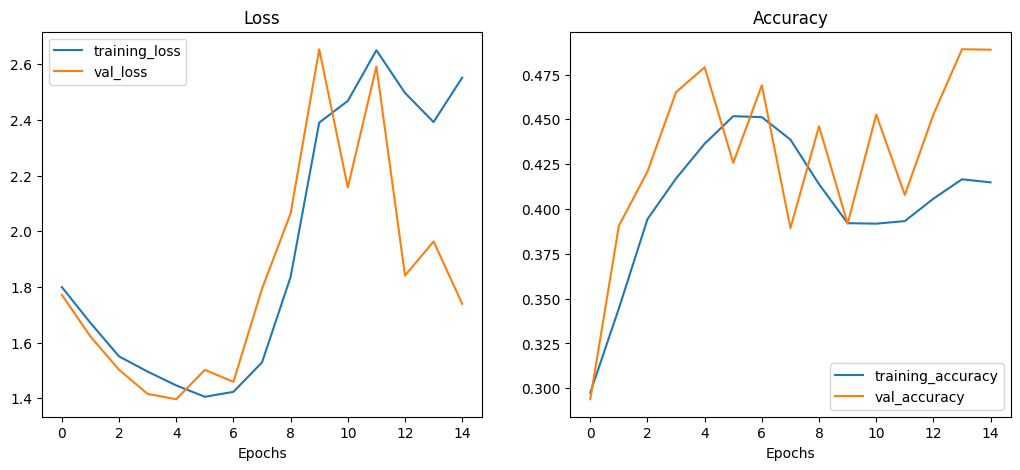

In [204]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.RandomZoom(0.1, 0.1)(x)
x = tf.keras.layers.RandomRotation(0.03)(x)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_9 = tf.keras.models.Model(inputs, outputs)

model_9.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.SGD(),
    metrics=['accuracy'],
)

history_9 = model_9.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=get_callbacks('model_9', True, 10),
)

model_9_preds = tf.argmax(model_9.predict(validation_data), axis=1)
model_9_results = calculate_results(y_true=validation_labels, y_pred=model_9_preds)

plot_loss_curves(history_9)

print(countEachClass(model_9_preds.numpy()))
print(model_9.evaluate(validation_data))

model_9_results

### Model 10 = Model s 13

In [205]:
from time import sleep
# Sleep for 5 minutes 
sleep(60 * 5)

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_10/20240122-042642
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_10/checkpoint.ckpt
Epoch 1/100
46/46 [==============================] - 37s 776ms/step - loss: 1.8601 - accuracy: 0.2690 - val_loss: 1.8180 - val_accuracy: 0.2298
Epoch 2/100
46/46 [==============================] - 36s 772ms/step - loss: 1.8323 - accuracy: 0.2874 - val_loss: 1.8431 - val_accuracy: 0.3033
Epoch 3/100
46/46 [==============================] - 34s 745ms/step - loss: 1.8511 - accuracy: 0.2812 - val_loss: 1.8131 - val_accuracy: 0.2316
Epoch 4/100
46/46 [==============================] - 34s 734ms/step - loss: 1.8268 - accuracy: 0.2935 - val_loss: 1.8064 - val_accuracy: 0.3033
Epoch 5/100
46/46 [==============================] - 34s 741ms/step - loss: 1.8168 - accuracy: 0.2955 - val_loss: 1.7916 - val_accuracy: 0.3033
Epoch 6/100
46/46 [==============================] - 35s 749ms/step - loss: 1.8138 - accuracy: 0.

{'accuracy': 40.91897770527461,
 'precision': 0.4594120693451079,
 'recall': 0.40918977705274606,
 'f1': 0.3878888628133032}

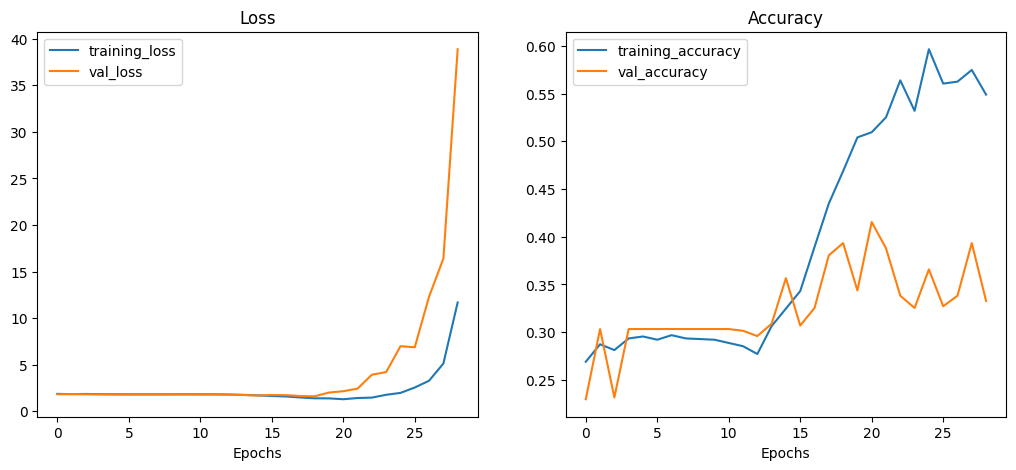

In [206]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_10 = tf.keras.models.Model(inputs, outputs)

model_10.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_10 = model_10.fit(
    train_data_10_percent,
    epochs=100,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=validation_data_15_percent,
    validation_steps=len(validation_data_15_percent),
    callbacks=get_callbacks('model_10', True, 10),
)

model_10_preds = tf.argmax(model_10.predict(validation_data), axis=1)
model_10_results = calculate_results(y_true=validation_labels, y_pred=model_10_preds)

plot_loss_curves(history_10)

print(countEachClass(model_10_preds.numpy()))
print(model_10.evaluate(validation_data))

model_10_results

### Model 11 = Model s 19

In [207]:
from time import sleep
# Sleep for 5 minutes 
sleep(60 * 5)

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_11/20240122-044848
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_11/checkpoint.ckpt
Epoch 1/100
460/460 [==============================] - 353s 763ms/step - loss: 1.7845 - accuracy: 0.3093 - val_loss: 1.5554 - val_accuracy: 0.4168
Epoch 2/100
460/460 [==============================] - 351s 763ms/step - loss: 1.4791 - accuracy: 0.4165 - val_loss: 1.3828 - val_accuracy: 0.4462
Epoch 3/100
460/460 [==============================] - 349s 758ms/step - loss: 1.3825 - accuracy: 0.4570 - val_loss: 1.3487 - val_accuracy: 0.4918
Epoch 4/100
460/460 [==============================] - 342s 744ms/step - loss: 1.3539 - accuracy: 0.4764 - val_loss: 1.3942 - val_accuracy: 0.4502
Epoch 5/100
460/460 [==============================] - 340s 738ms/step - loss: 1.4248 - accuracy: 0.4639 - val_loss: 2.0525 - val_accuracy: 0.4059
Epoch 6/100
460/460 [==============================] - 341s 740ms/step - loss: 1.9

{'accuracy': 49.184339314845026,
 'precision': 0.5044478476860863,
 'recall': 0.49184339314845027,
 'f1': 0.4628677995886087}

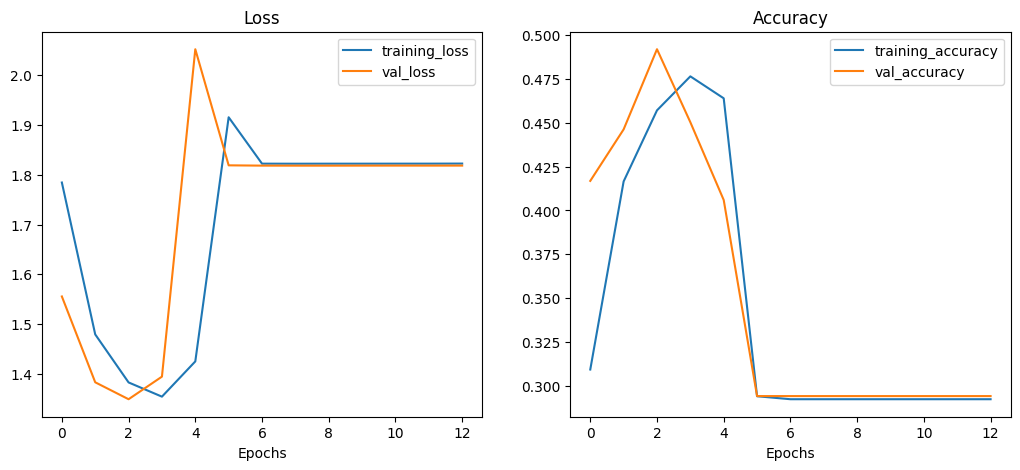

In [208]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1.0 / 255.0)(inputs)
x = tf.keras.layers.RandomZoom(0.1, 0.1)(x)
x = tf.keras.layers.RandomRotation(0.03)(x)
x = tf.keras.layers.Conv2D(128, 8, activation="relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation="relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation="relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation="relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation="relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

model_11 = tf.keras.models.Model(inputs, outputs)

model_11.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)

history_11 = model_11.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=get_callbacks("model_11", True, 10),
)

model_11_preds = tf.argmax(model_11.predict(validation_data), axis=1)
model_11_results = calculate_results(y_true=validation_labels, y_pred=model_11_preds)

plot_loss_curves(history_11)

print(countEachClass(model_11_preds.numpy()))
print(model_11.evaluate(validation_data))

model_11_results

### Model 12 = Model s 6

In [209]:
from time import sleep
# Sleep for 5 minutes 
sleep(60 * 5)

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_12/20240122-060915
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_12/checkpoint.ckpt
Epoch 1/100
460/460 [==============================] - 335s 726ms/step - loss: 1.7187 - accuracy: 0.3290 - val_loss: 1.4931 - val_accuracy: 0.4402
Epoch 2/100
460/460 [==============================] - 334s 726ms/step - loss: 1.4888 - accuracy: 0.4402 - val_loss: 1.7457 - val_accuracy: 0.4459
Epoch 3/100
460/460 [==============================] - 332s 722ms/step - loss: 2.1999 - accuracy: 0.3914 - val_loss: 2.0836 - val_accuracy: 0.4179
Epoch 4/100
460/460 [==============================] - 328s 712ms/step - loss: 13.9672 - accuracy: 0.3799 - val_loss: 20.0441 - val_accuracy: 0.3216
Epoch 5/100
460/460 [==============================] - 327s 710ms/step - loss: 586.9713 - accuracy: 0.3617 - val_loss: 1663.8442 - val_accuracy: 0.3159
Epoch 6/100
460/460 [==============================] - 327s 712ms/step - lo

{'accuracy': 44.01848830886351,
 'precision': 0.4489298981551459,
 'recall': 0.4401848830886351,
 'f1': 0.4023910266380357}

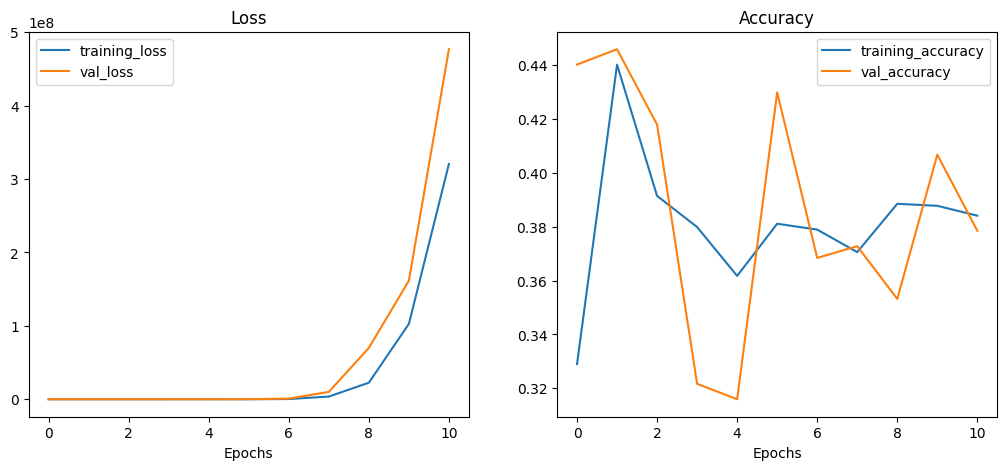

In [210]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}


inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_12 = tf.keras.models.Model(inputs, outputs)

model_12.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_12 = model_12.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=get_callbacks('model_12', True, 10),
)

model_12_preds = (tf.argmax(model_12.predict(validation_data), axis=1))
model_12_results = calculate_results(y_true=validation_labels, y_pred=model_12_preds)

plot_loss_curves(history_12)

print(countEachClass(model_12_preds.numpy()))
print(model_12.evaluate(validation_data))

model_12_results

### Model 13 = Model s 12

In [211]:
from time import sleep
# Sleep for 5 minutes 
sleep(60 * 5)

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_13/20240122-071447
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_13/checkpoint.ckpt
Epoch 1/100
460/460 [==============================] - 321s 696ms/step - loss: 1.8024 - accuracy: 0.2957 - val_loss: 1.7103 - val_accuracy: 0.3252
Epoch 2/100
460/460 [==============================] - 317s 688ms/step - loss: 1.4406 - accuracy: 0.4274 - val_loss: 1.3203 - val_accuracy: 0.4793
Epoch 3/100
460/460 [==============================] - 318s 692ms/step - loss: 1.2989 - accuracy: 0.4926 - val_loss: 1.3243 - val_accuracy: 0.4976
Epoch 4/100
460/460 [==============================] - 318s 692ms/step - loss: 1.2955 - accuracy: 0.5084 - val_loss: 1.7091 - val_accuracy: 0.4864
Epoch 5/100
460/460 [==============================] - 319s 694ms/step - loss: 1.7115 - accuracy: 0.4104 - val_loss: 2.1250 - val_accuracy: 0.2830
Epoch 6/100
460/460 [==============================] - 318s 692ms/step - loss: 4.6

{'accuracy': 47.933659597607395,
 'precision': 0.4978321599898745,
 'recall': 0.479336595976074,
 'f1': 0.46492675838797815}

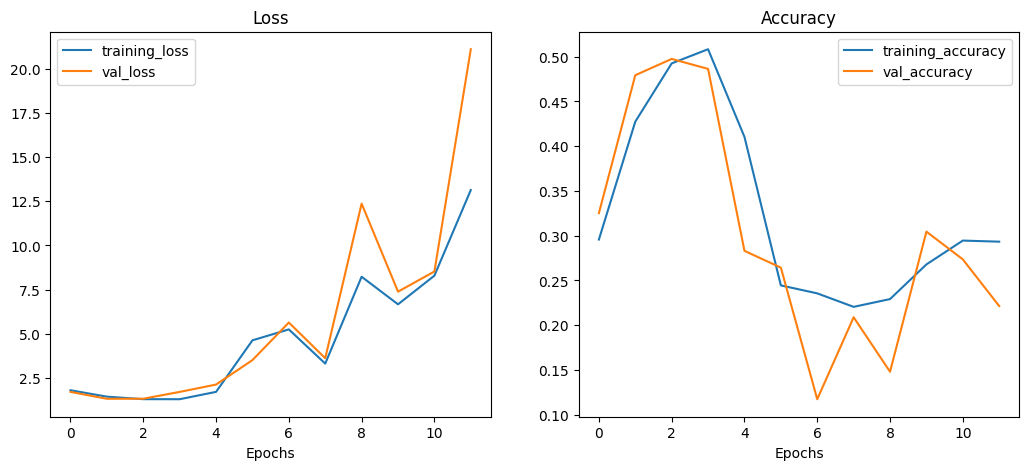

In [212]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_13 = tf.keras.models.Model(inputs, outputs)

model_13.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_13 = model_13.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=get_callbacks('model_13', True, 10),
)

model_13_preds = tf.argmax(model_13.predict(validation_data), axis=1)
model_13_results = calculate_results(y_true=validation_labels, y_pred=model_13_preds)

plot_loss_curves(history_13)

print(countEachClass(model_13_preds.numpy()))
print(model_13.evaluate(validation_data))

model_13_results

### Model 14 = Model s 7

In [213]:
from time import sleep
# Sleep for 5 minutes 
sleep(60 * 5)

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_14/20240122-082400
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_14/checkpoint.ckpt
Epoch 1/100
460/460 [==============================] - 322s 693ms/step - loss: 1.8490 - accuracy: 0.2879 - val_loss: 1.8191 - val_accuracy: 0.2942
Epoch 2/100
460/460 [==============================] - 318s 690ms/step - loss: 1.7810 - accuracy: 0.2979 - val_loss: 1.6822 - val_accuracy: 0.3146
Epoch 3/100
460/460 [==============================] - 318s 690ms/step - loss: 2.3815 - accuracy: 0.3026 - val_loss: 1.7776 - val_accuracy: 0.3173
Epoch 4/100
460/460 [==============================] - 317s 689ms/step - loss: 6.1083 - accuracy: 0.3238 - val_loss: 37.0977 - val_accuracy: 0.3483
Epoch 5/100
460/460 [==============================] - 317s 689ms/step - loss: 311.1124 - accuracy: 0.3327 - val_loss: 1624.3365 - val_accuracy: 0.3042
Epoch 6/100
460/460 [==============================] - 318s 690ms/step - los

{'accuracy': 31.45731375747689,
 'precision': 0.3035123989776846,
 'recall': 0.3145731375747689,
 'f1': 0.20953018427451905}

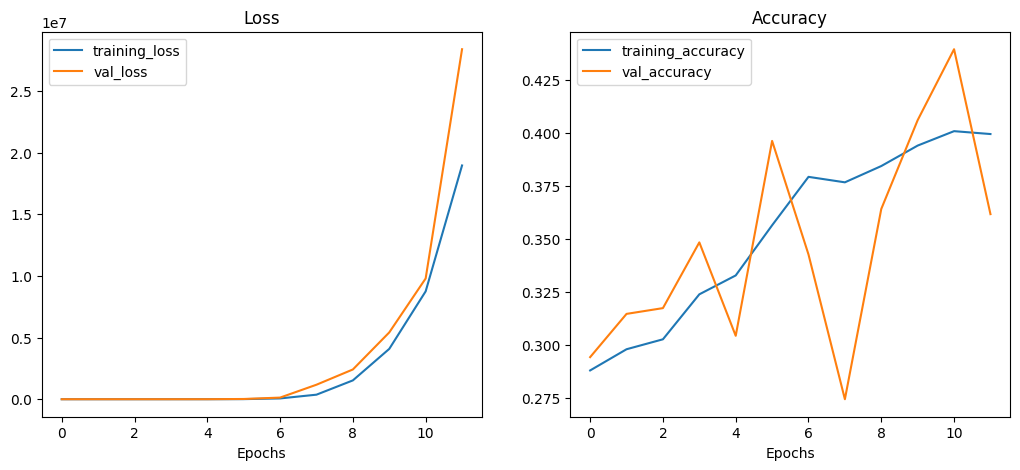

In [214]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}


inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_14 = tf.keras.models.Model(inputs, outputs)

model_14.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_14 = model_14.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=get_callbacks('model_14', True, 10),
)

model_14_preds = (tf.argmax(model_14.predict(validation_data), axis=1))
model_14_results = calculate_results(y_true=validation_labels, y_pred=model_14_preds)

plot_loss_curves(history_14)

print(countEachClass(model_14_preds.numpy()))
print(model_14.evaluate(validation_data))

model_14_results

### Model 15 = Model s 14

In [215]:
from time import sleep
# Sleep for 5 minutes 
sleep(60 * 5)

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_15/20240122-093247
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_15/checkpoint.ckpt
Epoch 1/10
460/460 [==============================] - 318s 689ms/step - loss: 1.8521 - accuracy: 0.2814 - val_loss: 1.8184 - val_accuracy: 0.2942
Epoch 2/10
460/460 [==============================] - 315s 684ms/step - loss: 1.7989 - accuracy: 0.3119 - val_loss: 1.8344 - val_accuracy: 0.2953
Epoch 3/10
460/460 [==============================] - 314s 682ms/step - loss: 1.8275 - accuracy: 0.2904 - val_loss: 1.8189 - val_accuracy: 0.2942
Epoch 4/10
460/460 [==============================] - 314s 683ms/step - loss: 1.8234 - accuracy: 0.2924 - val_loss: 1.8189 - val_accuracy: 0.2942
Epoch 5/10
460/460 [==============================] - 315s 684ms/step - loss: 1.8234 - accuracy: 0.2924 - val_loss: 1.8192 - val_accuracy: 0.2942
Epoch 6/10
460/460 [==============================] - 315s 684ms/step - loss: 1.8234 - 

/Users/mufaddalhamid/Documents/Learn/TensorFlow/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


115/115 [==============================] - 18s 158ms/step - loss: 1.8193 - accuracy: 0.2942
[1.8193351030349731, 0.29418161511421204]


{'accuracy': 29.41816204458945,
 'precision': 0.08654282580817234,
 'recall': 0.2941816204458945,
 'f1': 0.13374139215229325}

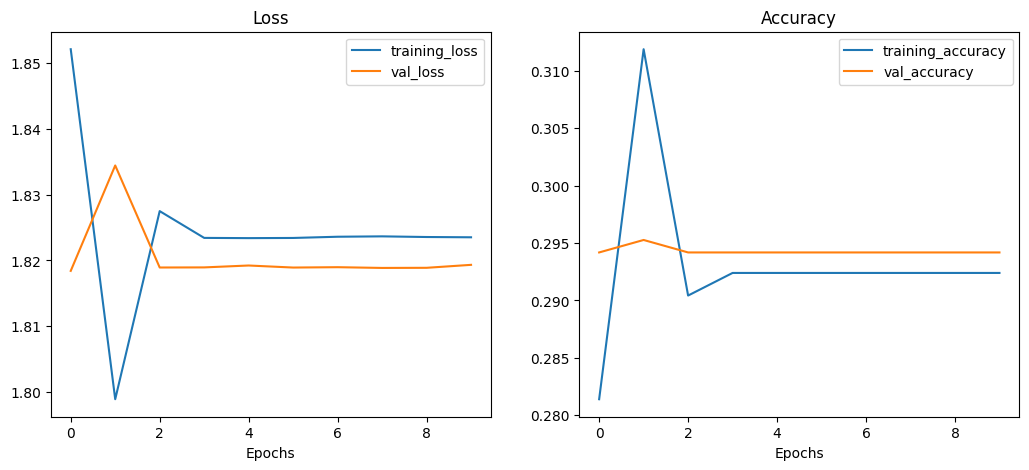

In [216]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_15 = tf.keras.models.Model(inputs, outputs)

model_15.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_15 = model_15.fit(
    train_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=get_callbacks('model_15', True, 10),
)

model_15_preds = tf.argmax(model_15.predict(validation_data), axis=1)
model_15_results = calculate_results(y_true=validation_labels, y_pred=model_15_preds)

plot_loss_curves(history_15)

print(countEachClass(model_15_preds.numpy()))
print(model_15.evaluate(validation_data))

model_15_results

### Getting all data result for model 7-15

In [229]:
model_7_all_preds = tf.argmax(model_7.predict(all_data), axis=1)
model_7_all_results = calculate_results(y_true=all_data_labels, y_pred=model_7_all_preds)

model_7_all_results

575/575 [==============================] - 93s 162ms/step


{'accuracy': 76.00456745147083,
 'precision': 0.7627986498261732,
 'recall': 0.7600456745147083,
 'f1': 0.7595463255684506}

In [230]:
model_8_all_preds = tf.argmax(model_8.predict(all_data), axis=1)
model_8_all_results = calculate_results(y_true=all_data_labels, y_pred=model_8_all_preds)

model_8_all_results

575/575 [==============================] - 94s 164ms/step


{'accuracy': 51.99826001848731,
 'precision': 0.5183017284532335,
 'recall': 0.5199826001848731,
 'f1': 0.5073644043347808}

In [231]:
model_9_all_preds = tf.argmax(model_9.predict(all_data), axis=1)
model_9_all_results = calculate_results(y_true=all_data_labels, y_pred=model_9_all_preds)

model_9_all_results

575/575 [==============================] - 94s 164ms/step


{'accuracy': 47.51237018106683,
 'precision': 0.4811849679135284,
 'recall': 0.47512370181066826,
 'f1': 0.4542898740068925}

In [232]:
model_10_all_preds = tf.argmax(model_10.predict(all_data), axis=1)
model_10_all_results = calculate_results(y_true=all_data_labels, y_pred=model_10_all_preds)

model_10_all_results

575/575 [==============================] - 95s 166ms/step


{'accuracy': 40.71012995486923,
 'precision': 0.45895070669650806,
 'recall': 0.4071012995486923,
 'f1': 0.3857821168510201}

In [233]:
model_11_all_preds = tf.argmax(model_11.predict(all_data), axis=1)
model_11_all_results = calculate_results(y_true=all_data_labels, y_pred=model_11_all_preds)

model_11_all_results

  1/575 [..............................] - ETA: 38s

575/575 [==============================] - 95s 165ms/step


{'accuracy': 48.70860747104562,
 'precision': 0.5024036042316602,
 'recall': 0.4870860747104562,
 'f1': 0.457268038678003}

In [234]:
model_12_all_preds = tf.argmax(model_12.predict(all_data), axis=1)
model_12_all_results = calculate_results(y_true=all_data_labels, y_pred=model_12_all_preds)

model_12_all_results

  1/575 [..............................] - ETA: 1:44

575/575 [==============================] - 95s 166ms/step


{'accuracy': 42.808982654559294,
 'precision': 0.4378983793978351,
 'recall': 0.42808982654559297,
 'f1': 0.38902518329546826}

In [235]:
model_13_all_preds = tf.argmax(model_13.predict(all_data), axis=1)
model_13_all_results = calculate_results(y_true=all_data_labels, y_pred=model_13_all_preds)

model_13_all_results

  1/575 [..............................] - ETA: 46s

575/575 [==============================] - 95s 166ms/step


{'accuracy': 48.76841933554456,
 'precision': 0.503530843412894,
 'recall': 0.4876841933554456,
 'f1': 0.47195781313282215}

In [236]:
model_14_all_preds = tf.argmax(model_14.predict(all_data), axis=1)
model_14_all_results = calculate_results(y_true=all_data_labels, y_pred=model_14_all_preds)

model_14_all_results

  1/575 [..............................] - ETA: 30s

575/575 [==============================] - 95s 166ms/step


{'accuracy': 31.455603284215105,
 'precision': 0.30922275585744624,
 'recall': 0.31455603284215106,
 'f1': 0.21064609711283208}

In [237]:
model_15_all_preds = tf.argmax(model_15.predict(all_data), axis=1)
model_15_all_results = calculate_results(y_true=all_data_labels, y_pred=model_15_all_preds)

model_15_all_results

  1/575 [..............................] - ETA: 41s

575/575 [==============================] - 95s 165ms/step


/Users/mufaddalhamid/Documents/Learn/TensorFlow/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 29.275188951117393,
 'precision': 0.08570366881236259,
 'recall': 0.2927518895111739,
 'f1': 0.13259105557334683}

In [252]:
def prepare_test_file(model, model_name):
    test_dir = DIR_NAME + "test/"
    test_data = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        image_size=(224, 224),
        batch_size=32,
        labels=None,
        shuffle=False,
    )

    test_preds = tf.argmax(model.predict(test_data), axis=1)
    test_img_names = [name.split("/")[-1] for name in test_data.file_paths]
    pd.DataFrame({"file_name": test_img_names, "label": test_preds}).to_csv(
        f"test_preds_{model_name}.csv", index=False
    )

    return test_preds, test_img_names

In [ ]:
prepare_test_file(model_7, 'model_7')

In [255]:
prepare_test_file(model_8, 'model_8')
prepare_test_file(model_9, 'model_9')
prepare_test_file(model_13, 'model_13')
prepare_test_file(model_11, 'model_11');

Found 5751 files belonging to 1 classes.
180/180 [==============================] - 29s 159ms/step
Found 5751 files belonging to 1 classes.
180/180 [==============================] - 29s 161ms/step
Found 5751 files belonging to 1 classes.
180/180 [==============================] - 29s 160ms/step
Found 5751 files belonging to 1 classes.
180/180 [==============================] - 29s 160ms/step


### Model 16 = Model 8 + more layer

In [238]:
from time import sleep
# Sleep for 5 minutes 
sleep(60 * 5)

In [266]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.RandomZoom(0.1, 0.1)(x)
x = tf.keras.layers.RandomRotation(0.03)(x)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_16 = tf.keras.models.Model(inputs, outputs)

model_16.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_16 = model_16.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=get_callbacks('model_16', True, 20),
)

model_16_preds = tf.argmax(model_16.predict(validation_data), axis=1)
model_16_results = calculate_results(y_true=validation_labels, y_pred=model_16_preds)

plot_loss_curves(history_16)

print(countEachClass(model_16_preds.numpy()))
print(model_16.evaluate(validation_data))

model_16_results

Saving TensorBoard log files to: attributes_from_fashion/tensorboard/model_16/20240122-124501
Saving model checkpoints to: attributes_from_fashion/checkpoint/model_16/checkpoint.ckpt
Epoch 1/100
326/460 [====================>.........] - ETA: 4:59 - loss: 1.8664 - accuracy: 0.2863

KeyboardInterrupt: 

### Model 17 = Model 8 + param change

In [ ]:
from time import sleep
# Sleep for 5 minutes 
sleep(60 * 5)

In [ ]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.RandomZoom(0.1, 0.1)(x)
x = tf.keras.layers.RandomRotation(0.03)(x)
x = tf.keras.layers.Conv2D(512, 16, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(256, 12, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_17 = tf.keras.models.Model(inputs, outputs)

model_17.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_17 = model_17.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=get_callbacks('model_17', True, 20),
)

model_17_preds = tf.argmax(model_17.predict(validation_data), axis=1)
model_17_results = calculate_results(y_true=validation_labels, y_pred=model_17_preds)

plot_loss_curves(history_17)

print(countEachClass(model_17_preds.numpy()))
print(model_17.evaluate(validation_data))

model_17_results

### Model 18 = Model 16 + Model 17

In [ ]:
from time import sleep
# Sleep for 5 minutes 
sleep(60 * 5)

In [ ]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.RandomZoom(0.1, 0.1)(x)
x = tf.keras.layers.RandomRotation(0.03)(x)
x = tf.keras.layers.Conv2D(1024, 20, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(512, 16, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(256, 12, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_18 = tf.keras.models.Model(inputs, outputs)

model_18.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_18 = model_18.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=get_callbacks('model_18', True, 20),
)

model_18_preds = tf.argmax(model_18.predict(validation_data), axis=1)
model_18_results = calculate_results(y_true=validation_labels, y_pred=model_18_preds)

plot_loss_curves(history_18)

print(countEachClass(model_18_preds.numpy()))
print(model_18.evaluate(validation_data))

model_18_results

### Model 19 = Model 8 - data agumentation

In [ ]:
from time import sleep
# Sleep for 5 minutes 
sleep(60 * 5)

In [ ]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_19 = tf.keras.models.Model(inputs, outputs)

model_19.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_19 = model_19.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=get_callbacks('model_19', True, 10),
)

model_19_preds = tf.argmax(model_19.predict(validation_data), axis=1)
model_19_results = calculate_results(y_true=validation_labels, y_pred=model_19_preds)

plot_loss_curves(history_19)

print(countEachClass(model_19_preds.numpy()))
print(model_19.evaluate(validation_data))

model_19_results

### Model 20 = Model 8 + more layer - data aumentation

In [ ]:
from time import sleep
# Sleep for 5 minutes 
sleep(60 * 5)

In [ ]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_20 = tf.keras.models.Model(inputs, outputs)

model_20.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_20 = model_20.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=get_callbacks('model_20', True, 20),
)

model_20_preds = tf.argmax(model_20.predict(validation_data), axis=1)
model_20_results = calculate_results(y_true=validation_labels, y_pred=model_20_preds)

plot_loss_curves(history_20)

print(countEachClass(model_20_preds.numpy()))
print(model_20.evaluate(validation_data))

model_20_results

### Model 21 = Model 8 + param change - data aumentation

In [ ]:
from time import sleep
# Sleep for 5 minutes 
sleep(60 * 5)

In [ ]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(512, 16, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(256, 12, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_21 = tf.keras.models.Model(inputs, outputs)

model_21.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_21 = model_21.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=get_callbacks('model_21', True, 20),
)

model_21_preds = tf.argmax(model_21.predict(validation_data), axis=1)
model_21_results = calculate_results(y_true=validation_labels, y_pred=model_21_preds)

plot_loss_curves(history_21)

print(countEachClass(model_21_preds.numpy()))
print(model_21.evaluate(validation_data))

model_21_results

### Model 22 = Model 20 + Model 21

In [ ]:
from time import sleep
# Sleep for 5 minutes 
sleep(60 * 5)

In [ ]:
class_weights = {i: total / (len(label) * j) for i, j in enumerate(label)}

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255.)(inputs)
x = tf.keras.layers.Conv2D(1024, 20, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(512, 16, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(256, 12, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(128, 8, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model_22 = tf.keras.models.Model(inputs, outputs)

model_22.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

history_22 = model_22.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=get_callbacks('model_22', True, 20),
)

model_22_preds = tf.argmax(model_22.predict(validation_data), axis=1)
model_22_results = calculate_results(y_true=validation_labels, y_pred=model_22_preds)

plot_loss_curves(history_22)

print(countEachClass(model_22_preds.numpy()))
print(model_22.evaluate(validation_data))

model_22_results